In [761]:
import numpy as np
import pandas as pd

import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage , fcluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

# Importation des données

In [762]:
df_volaille_2020 = pd.read_csv('df_volaille_2020.csv')
df_volaille_2020.head()

Zone  \
0     Afghanistan   
1  Afrique du Sud   
2         Albanie   
3         Algérie   
4       Allemagne   

   Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
0                                               1.71                               
1                                              34.86                               
2                                              13.94                               
3                                               6.38                               
4                                              18.34                               

   Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
0                                                 67                 
1                                               2067                 
2                                                 40                 
3                                                280                 
4                                               1626                 

   Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
0                                                  0                
1                                                 49                
2                                                  0                
3                                                  1                
4                                                575                

   Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
0                                                 36                
1                                                425                
2                                                 26                
3                                                  0                
4                                                766                

   Pertes_Viande de Volailles_Milliers de tonnes  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Population totale_Population-Estimations_1000 personnes  \
0                                          38972.230         
1                                          58801.927         
2                                           2866.849         
3                                          43451.666         
4                                          83328.988         

   Production_Viande de Volailles_Milliers de tonnes  \
0                                                 28   
1                                               1881   
2                                                 14   
3                                                284   
4                                               1572   

   Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
0                                         508.453722                  
1                                        5094.384038                  
2                                        5180.914198                  
3                                        3367.963003                  
4                                       45908.724713                  

   Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice  \
0                                              -2.73                              
1                                              -0.24                              
2                                               0.08                              
3                                              -0.86                              
4                                               0.67                              

   Variation de stock_Viande de Volailles_Milliers de tonnes  
0                                                 -2          
1                                                189   

In [763]:
df_volaille_2020.set_index('Zone',inplace = True)

# Création de nos fonctions

Fonction pour afficher les cercles de corrélation :

In [764]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Fonction pour afficher la projections des individus sur les axes de l'ACP :

In [765]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



# Analyse 1

## Préparation

In [766]:
sns.set()

In [767]:
df_volaille_2020.shape

(182, 10)

Dispersion des données : 

In [768]:
df_volaille_2020.describe()

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
count                                         182.000000                               
mean                                           21.821209                               
std                                            16.887422                               
min                                             0.480000                               
25%                                             6.430000                               
50%                                            19.510000                               
75%                                            32.602500                               
max                                            74.650000                               

       Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
count                                         182.000000                 
mean                                          426.879121                 
std                                           795.446000                 
min                                             1.000000                 
25%                                            30.750000                 
50%                                           104.000000                 
75%                                           328.000000                 
max                                          4632.000000                 

       Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
count                                         182.000000                
mean                                           52.181319                
std                                           179.844792                
min                                             0.000000                
25%                                             0.000000                
50%                                             0.000000                
75%                                            10.750000                
max                                          1361.000000                

       Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
count                                         182.000000                
mean                                           79.697802                
std                                           166.102018                
min                                             0.000000                
25%                                             3.000000                
50%                                            19.000000                
75%                                            81.750000                
max                                          1022.000000                

       Pertes_Viande de Volailles_Milliers de tonnes  \
count                                     182.000000   
mean                                        3.824176   
std                                        30.031694   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                         0.000000   
max                                       389.000000   

       Population totale_Population-Estimations_1000 personnes  \
count                                       1.820000e+02         
mean                                        3.200108e+04         
std                                         1.095133e+05         
min                                         1.231500e+01         
25%                                         2.503424e+03         
50%                                         9.588474e+03         
75%                                         2.913408e+04         
max                                         1.396387e+06         

       Production_Viande de Volailles_Milliers de tonnes  \
count                                         182.000000   
mean       

Extaction de la matrice des données dans `X` : 

In [769]:
X = df_volaille_2020.values
X[:5]

array([[ 1.71000000e+00,  6.70000000e+01,  0.00000000e+00,
         3.60000000e+01,  0.00000000e+00,  3.89722300e+04,
         2.80000000e+01,  5.08453722e+02, -2.73000000e+00,
        -2.00000000e+00],
       [ 3.48600000e+01,  2.06700000e+03,  4.90000000e+01,
         4.25000000e+02,  0.00000000e+00,  5.88019270e+04,
         1.88100000e+03,  5.09438404e+03, -2.40000000e-01,
         1.89000000e+02],
       [ 1.39400000e+01,  4.00000000e+01,  0.00000000e+00,
         2.60000000e+01,  0.00000000e+00,  2.86684900e+03,
         1.40000000e+01,  5.18091420e+03,  8.00000000e-02,
         0.00000000e+00],
       [ 6.38000000e+00,  2.80000000e+02,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.34516660e+04,
         2.84000000e+02,  3.36796300e+03, -8.60000000e-01,
         3.00000000e+00],
       [ 1.83400000e+01,  1.62600000e+03,  5.75000000e+02,
         7.66000000e+02,  0.00000000e+00,  8.33289880e+04,
         1.57200000e+03,  4.59087247e+04,  6.70000000e-01,
         1.

Extraction des noms des pays dans `names` :

In [770]:
names = df_volaille_2020.index
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Venezuela (République bolivarienne du)', 'Viet Nam', 'Yémen', 'Zambie',
       'Zimbabwe', 'Égypte', 'Émirats arabes unis', 'Équateur', 'Éthiopie',
       'Îles Salomon'],
      dtype='object', name='Zone', length=182)

Extraction des noms des variables dans `features` : 

In [771]:
features = df_volaille_2020.columns
features

Index(['Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg',
       'Disponibilité intérieure_Viande de Volailles_Milliers de tonnes',
       'Exportations - Quantité_Viande de Volailles_Milliers de tonnes',
       'Importations - Quantité_Viande de Volailles_Milliers de tonnes',
       'Pertes_Viande de Volailles_Milliers de tonnes',
       'Population totale_Population-Estimations_1000 personnes',
       'Production_Viande de Volailles_Milliers de tonnes',
       'Valeur US dollars par habitant_Produit Intérieur Brut_US dollars',
       'Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice',
       'Variation de stock_Viande de Volailles_Milliers de tonnes'],
      dtype='object')

## ACP

### Standardisation des données

In [772]:
scaler = StandardScaler()

In [773]:
scaler.fit(X)

StandardScaler()

In [774]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-1.19418394, -0.4536724 , -0.2909468 , -0.26380383, -0.12768928,
         0.06383139, -0.48735043, -0.68063511, -2.75886933, -0.28075526],
       [ 0.77423069,  2.06757638, -0.01773804,  2.08459091, -0.12768928,
         0.24540205,  1.86905586, -0.43435709, -0.13342597,  3.59210753],
       [-0.46797848, -0.48770925, -0.2909468 , -0.32417387, -0.12768928,
        -0.26676761, -0.50515382, -0.42971017,  0.20398041, -0.24020172],
       [-0.9168839 , -0.1851594 , -0.28537111, -0.48113599, -0.12768928,
         0.10484736, -0.16180266, -0.527071  , -0.78715082, -0.17937141],
       [-0.20671078,  1.51164102,  2.91507436,  4.14320943, -0.12768928,
         0.46998414,  1.47610954,  1.75749365,  0.82607341,  2.53771557]])

Je vérifie que la moyenne est bien égale à 0 et l'écart type égal à 1 : 

In [775]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9
mean -0.0 -0.0 -0.0  0.0  0.0 -0.0  0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

Je m'intéresse aux 10 premières composantes : 

In [776]:
n_components = 10

In [777]:
pca = PCA(n_components=n_components)

In [778]:
pca.fit(X_scaled)

PCA(n_components=10)

On regarde maintenant le pourcentage de variance captée par chacune des composantes :

In [779]:
(pca.explained_variance_ratio_*100).round(2)

array([30.59, 20.21, 10.81,  9.72,  9.03,  7.03,  5.14,  4.14,  3.33,
        0.  ])

Ici la 1ère composante *capte* 31% de la variance de nos données initiales, la 2ème 20% etc etc.

In [780]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([30.59, 20.21, 10.81,  9.72,  9.03,  7.03,  5.14,  4.14,  3.33,
        0.  ])

On s'intéresse maintenant à la somme cumulée des variances captées par les composantes de l'ACP : 

In [781]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 31.,  51.,  62.,  71.,  80.,  87.,  93.,  97., 100., 100.])

On visualise ensuite à l'aide d'un graphique les variances captées par les 10 composantes ainsi que la somme cumulée : 

In [782]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

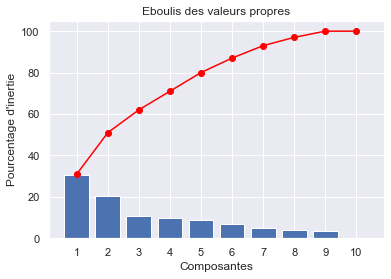

In [783]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Composantes")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.xticks(x_list)
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

On voit ici que près de 80% de la variance est comprise dans les 5 premières composantes.

Les 8 premières composantes comprennent elles plus de 95% de la variance. 

Nous calculons maintenant nos composantes et l'affichons de manière lisible : 

In [784]:
pcs = pca.components_

In [785]:
pcs = pd.DataFrame(pcs)

In [786]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

<AxesSubplot:>

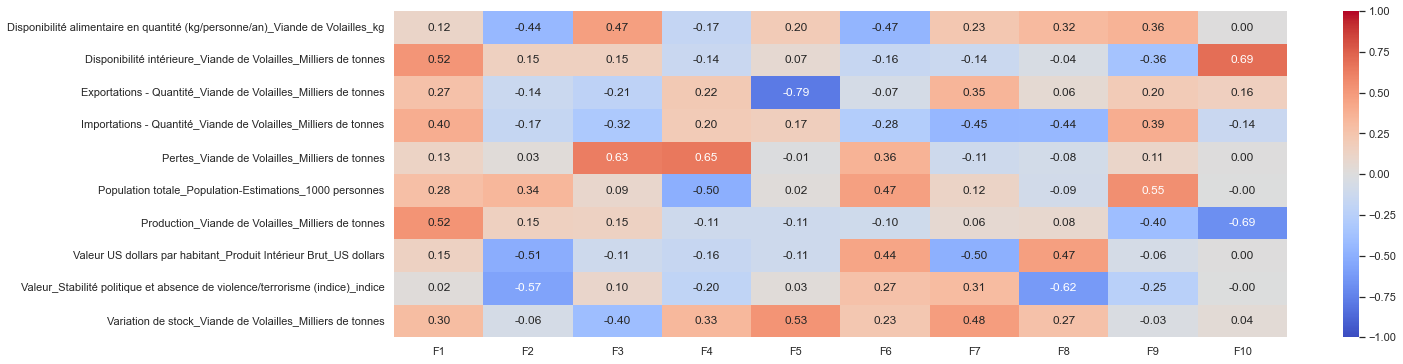

In [787]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Définissons nos axes x et y pour nos 2 premières composantes :

In [788]:
x, y = 0,1

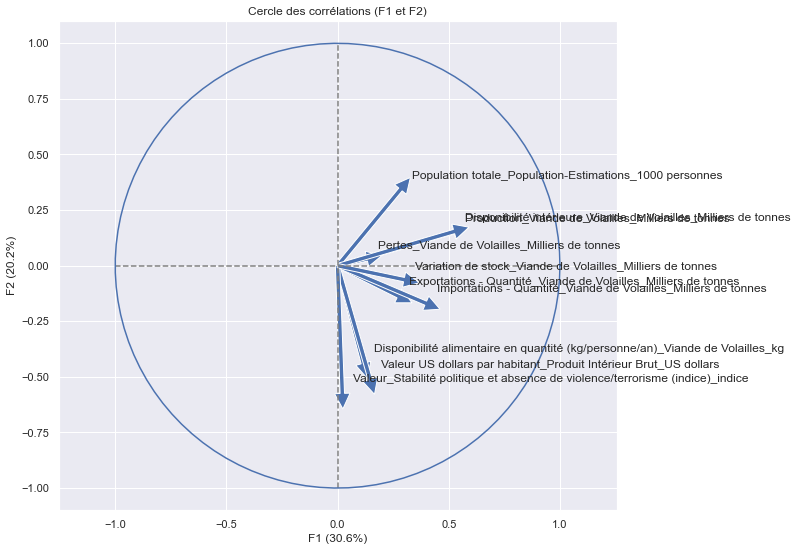

In [789]:
correlation_graph(pca, (x,y), features)

Et pour F3 et F4 :

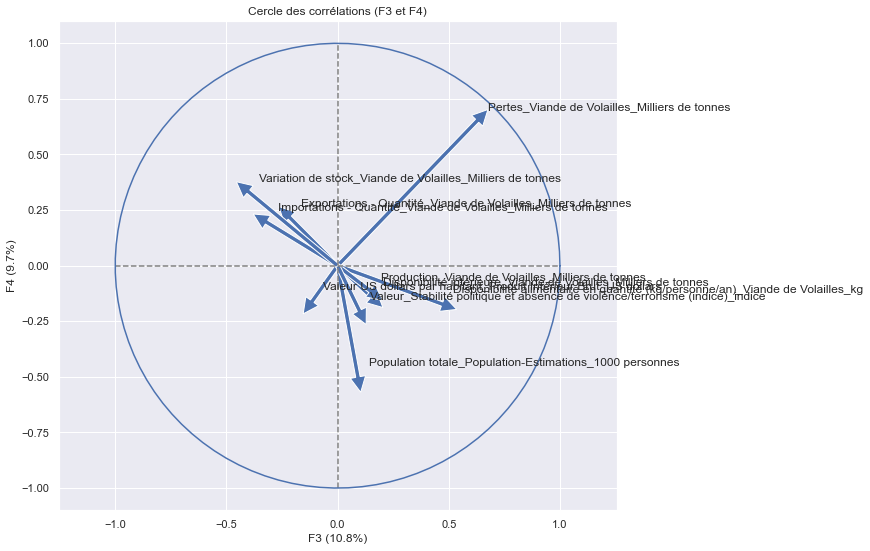

In [790]:
correlation_graph(pca, (2,3), features)

Nous voulons maintenant projeter nos pays sur les axes de nos composantes. Pour cela nous calculons les coordonnées de chaque pays les axes de chacune de nos composantes : 

In [791]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-1.05517958e+00,  2.43307303e+00, -7.09747207e-01,
         6.67746233e-01, -1.72048778e-01, -3.45109063e-01,
        -8.57348557e-01,  1.02795623e+00,  5.23599566e-01,
         9.60689678e-04],
       [ 4.02863813e+00,  6.54692221e-02, -1.17110217e+00,
         8.54503058e-01,  2.40506129e+00, -7.94445591e-01,
         1.00227244e+00,  2.15262384e-01, -3.12284429e-01,
        -6.68963161e-04],
       [-1.00374337e+00,  1.70414777e-01, -1.41628435e-01,
         7.79635192e-02,  2.55999095e-02,  9.69174847e-02,
         1.16240993e-01, -4.04184480e-01, -1.53636638e-01,
        -3.02858113e-06],
       [-6.90725657e-01,  1.23445974e+00, -2.83594374e-01,
         9.44510581e-02, -8.66955968e-02,  1.46461424e-01,
        -1.20023512e-01,  9.33213477e-02, -1.68906605e-01,
         3.00713522e-05],
       [ 5.12347303e+00, -1.92258487e+00, -2.77503109e+00,
         1.17597680e+00, -5.19508932e-01,  1.03538407e-01,
        -3.40666810e-01, -6.83958123e-01,  8.51123667e-01,
        -9.

Projection des pays sur les axes F1 et F2 : 

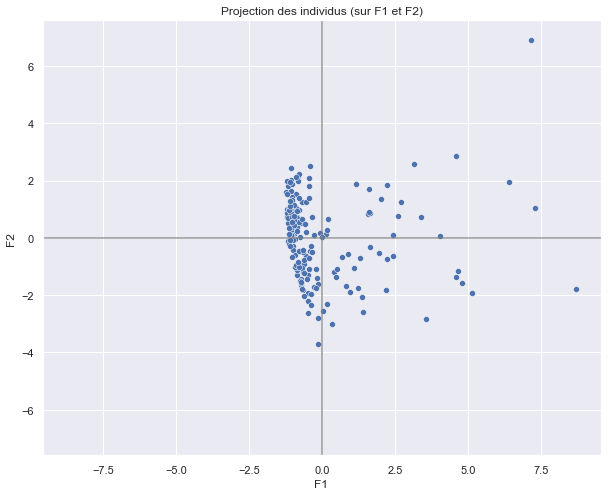

In [792]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y)

La même chose mais en affichant les noms des pays (même si seuls les pays éloignés des autres sont lisibles) : 

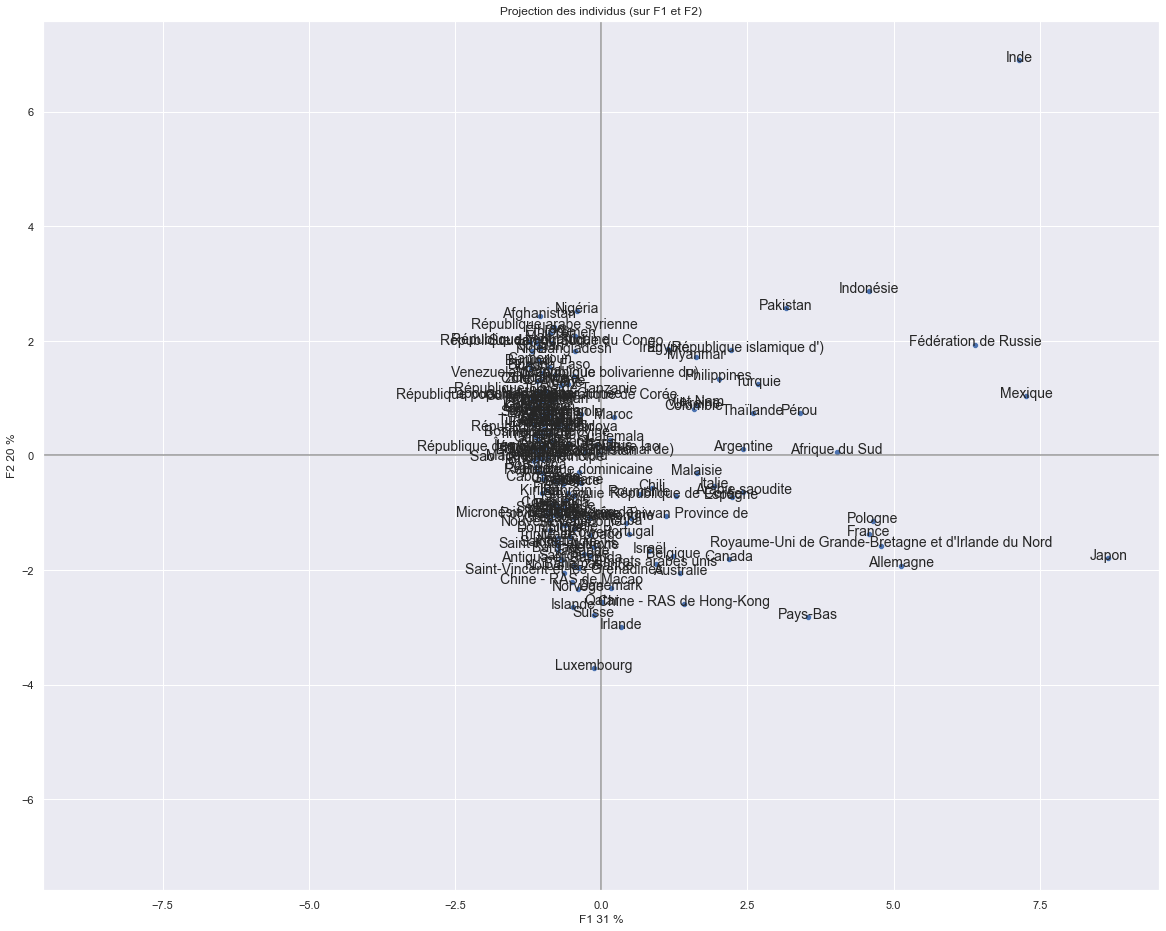

In [793]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

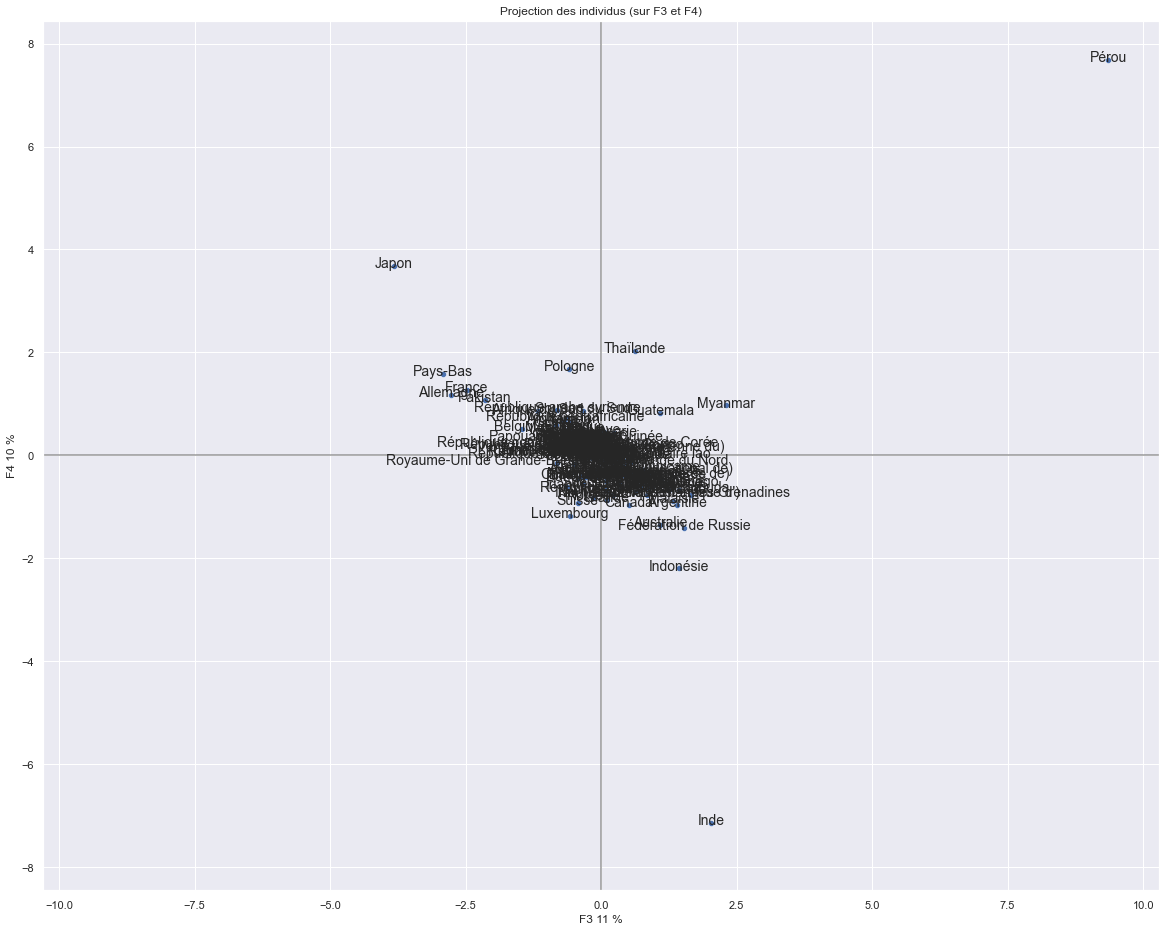

In [794]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

## Kmeans

In [684]:
df_volaille_2020.head()

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                            
Afghanistan                                                  1.71                               
Afrique du Sud                                              34.86                               
Albanie                                                     13.94                               
Algérie                                                      6.38                               
Allemagne                                                   18.34                               

                Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                              
Afghanistan                                                    67                 
Afrique du Sud                                               2067                 
Albanie                                                        40                 
Algérie                                                       280                 
Allemagne                                                    1626                 

                Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                             
Afghanistan                                                     0                
Afrique du Sud                                                 49                
Albanie                                                         0                
Algérie                                                         1                
Allemagne                                                     575                

                Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                             
Afghanistan                                                    36                
Afrique du Sud                                                425                
Albanie                                                        26                
Algérie                                                         0                
Allemagne                                                     766                

                Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                            
Afghanistan                                                 0   
Afrique du Sud                                              0   
Albanie                                                     0   
Algérie                                                     0   
Allemagne                                                   0   

                Population totale_Population-Estimations_1000 personnes  \
Zone                                                                      
Afghanistan                                             38972.230         
Afrique du Sud                                          58801.927         
Albanie                                                  2866.849         
Algérie                                                 43451.666         
Allemagne                                               83328.988         

                Production_Viande de Volailles_Milliers de tonnes  \
Zone                                                                
Afghanistan                                                    28   
Afrique du Sud                                               1881   
Albanie                                                        14   
Algérie                                                       284   
Allemagne                                                    1572   

                Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
Zone                                                  

In [685]:
df_volaille_2020.shape

(182, 10)

### Méthode du coude pour déterminer le nombre de clusters

In [686]:
# Une liste vide pour enregistrer les inerties :  
inertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(df_volaille_2020)
    
    # On enregistre l'inertie obtenue dans notre liste vide : 
    inertia_list.append(kmeans.inertia_)

C:\Users\barba\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


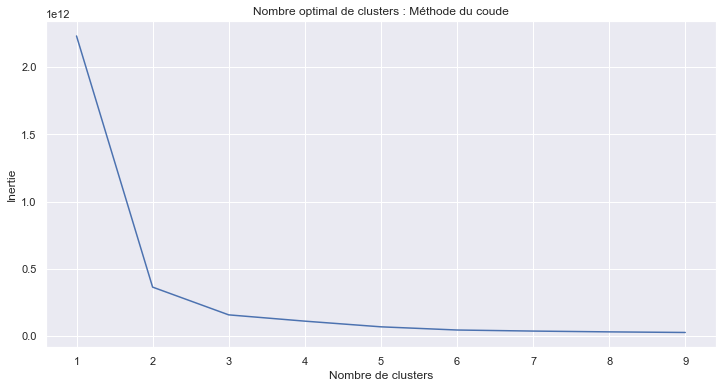

In [687]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("Inertie")
ax.set_xlabel("Nombre de clusters")
plt.title("Nombre optimal de clusters : Méthode du coude")

ax = plt.plot(k_list, inertia_list)

Le "bas" de la courbe du coude est atteint pour 3 clusters, nous allons donc faire appliquer la méthode des Kmeans avec 3 clusters.

### Clustering 

In [688]:
# On instancie notre Kmeans avec 3 clusters : 
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)

# On l'entraine : 
kmeans.fit(df_volaille_2020)

# On peut stocker nos clusters dans une variable labels : 
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 0])

J'ajoute dans mon dataframe une colonne correspondant au cluster attribué à chaque pays par cette méthode :

In [689]:
df_volaille_2020['kmeans']= labels

J'affiche la liste de pays de chaque cluster si le nombre de pays est inférieur à 30 (pour plus de lisibilité) :

In [690]:
if df_volaille_2020.loc[df_volaille_2020['kmeans']==0].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['kmeans']==0]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [691]:
if df_volaille_2020.loc[df_volaille_2020['kmeans']==1].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['kmeans']==1]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                  
Inde                                                2.6                               

      Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                    
Inde                                               3594                 

      Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                   
Inde                                                  4                

      Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                   
Inde                                                  0                

      Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                  
Inde                                              0   

      Population totale_Population-Estimations_1000 personnes  \
Zone                                                            
Inde                                        1396387.127         

      Production_Viande de Volailles_Milliers de tonnes  \
Zone                                                      
Inde                                               3597   

      Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
Zone                                                                     
Inde                                        1930.971218                  

      Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice  \
Zone                                                                                 
Inde                                              -0.86                              

      Variation de stock_Viande de Volailles_Milliers de tonnes  kmeans  
Zone                                                                     
Inde                                                  0               1

In [692]:
if df_volaille_2020.loc[df_volaille_2020['kmeans']==2].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['kmeans']==2]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                              
Allemagne                                                                     18.34                               
Bangladesh                                                                     1.64                               
Fédération de Russie                                                          30.78                               
Indonésie                                                                     13.69                               
Iran (République islamique d')                                                25.99                               
Japon                                                                         22.28                               
Mexique                                                                       35.93                               
Nigéria                                                                        1.16                               
Pakistan                                                                       6.15                               
Philippines                                                                   15.85                               
République démocratique du Congo                                               1.26                               
Turquie                                                                       19.99                               
Viet Nam                                                                      15.81                               
Égypte                                                                        14.33                               
Éthiopie                                                                       0.59                               

                                  Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                
Allemagne                                                                      1626                 
Bangladesh                                                                      269                 
Fédération de Russie                                                           4596                 
Indonésie                                                                      3745                 
Iran (République islamique d')                                                 2182                 
Japon                                                                          2868                 
Mexique                                                                        4632                 
Nigéria                                                                         239                 
Pakistan                                                                       1359                 
Philippines                                                                    1737                 
République démocratique du Congo                                                113                 
Turquie                                                                        1686                 
Viet Nam                                                                       1539                 
Égypte                                                                         1467                 
Éthiopie                                                                         68                 

                                  Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                               
Allemagne                                                                       575                
Bangladesh                                                  

In [693]:
# On peut stocker nos centroids dans une variable : 
centroids = kmeans.cluster_centers_
centroids

array([[ 2.25606627e+01,  2.76939759e+02,  4.85722892e+01,
         6.48132530e+01,  3.84939759e+00,  1.43074800e+04,
         2.68132530e+02,  1.35723803e+04, -3.86098239e-02,
         7.40361446e+00],
       [ 2.60000000e+00,  3.59400000e+03,  4.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.39638713e+06,
         3.59700000e+03,  1.93097122e+03, -8.60000000e-01,
         0.00000000e+00],
       [ 1.49193333e+01,  1.87506667e+03,  9.53333333e+01,
         2.49733333e+02,  3.80000000e+00,  1.36851129e+05,
         1.78253333e+03,  9.61823306e+03, -8.92000000e-01,
         6.18000000e+01]])

## Clustering hierarchique

In [795]:
Z = linkage(df_volaille_2020, method="ward")

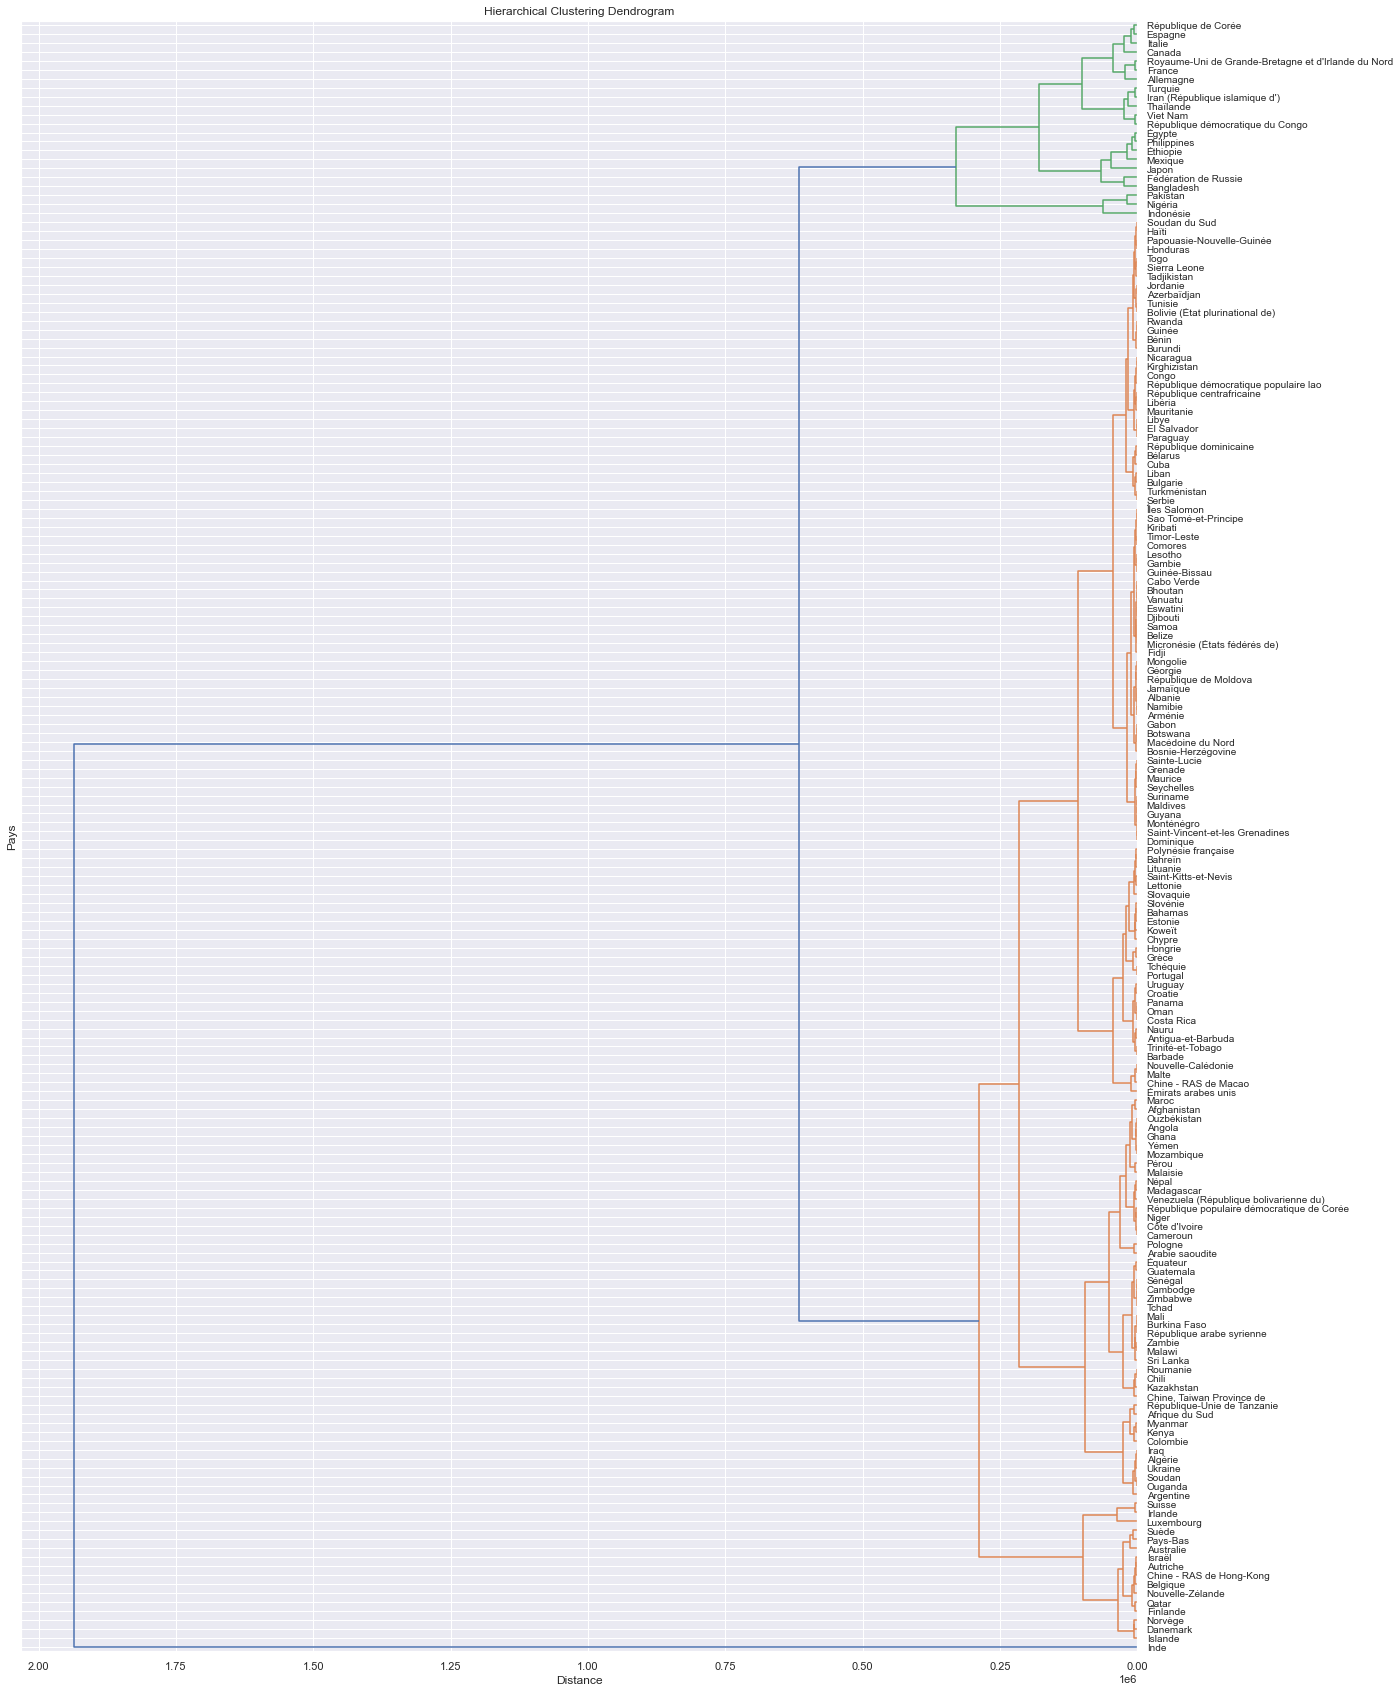

In [796]:
fig, ax = plt.subplots(1, 1, figsize=(20, 30))

_ = dendrogram(Z,  ax=ax, orientation = 'left', labels = names, leaf_font_size = 10, color_threshold = 500000)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Pays")
plt.xlabel("Distance")
plt.show()

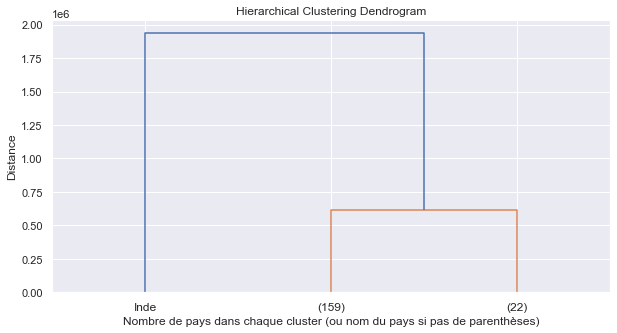

In [798]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

_ = dendrogram(Z, p=3, truncate_mode="lastp", ax=ax, labels = names)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nombre de pays dans chaque cluster (ou nom du pays si pas de parenthèses)")
plt.ylabel("Distance")
plt.show()

In [700]:
CAH = fcluster(Z,t =n_clusters, criterion ='maxclust')
print(CAH)

[1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 2 1 1 1
 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 2 1]


J'ajoute dans mon dataframe une colonne correspondant au cluster attribué à chaque pays par cette méthode :

In [701]:
df_volaille_2020['CAH']= CAH

J'affiche la liste de pays de chaque cluster si le nombre de pays est inférieur à 30 (pour plus de lisibilité) :

In [702]:
if df_volaille_2020.loc[df_volaille_2020['CAH']==1].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['CAH']==1]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [703]:
if df_volaille_2020.loc[df_volaille_2020['CAH']==2].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['CAH']==2]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                                                
Allemagne                                                                                       18.34                               
Bangladesh                                                                                       1.64                               
Canada                                                                                          40.10                               
Espagne                                                                                         33.60                               
France                                                                                          22.97                               
Fédération de Russie                                                                            30.78                               
Indonésie                                                                                       13.69                               
Iran (République islamique d')                                                                  25.99                               
Italie                                                                                          19.62                               
Japon                                                                                           22.28                               
Mexique                                                                                         35.93                               
Nigéria                                                                                          1.16                               
Pakistan                                                                                         6.15                               
Philippines                                                                                     15.85                               
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                              32.73                               
République de Corée                                                                             22.76                               
République démocratique du Congo                                                                 1.26                               
Thaïlande                                                                                       11.40                               
Turquie                                                                                         19.99                               
Viet Nam                                                                                        15.81                               
Égypte                                                                                          14.33                               
Éthiopie                                                                                         0.59                               

                                                    Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                  
Allemagne                                                                                        1626                 
Bangladesh                                                                                        269                 
Canada                                                                                           1510                 
Espagne                                                                                          1584                 
France                                                                                           1582                 
Fédération de Russie      

In [704]:
if df_volaille_2020.loc[df_volaille_2020['CAH']==3].shape < (30,10) :
    x= df_volaille_2020.loc[df_volaille_2020['CAH']==3]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                  
Inde                                                2.6                               

      Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                    
Inde                                               3594                 

      Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                   
Inde                                                  4                

      Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                   
Inde                                                  0                

      Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                  
Inde                                              0   

      Population totale_Population-Estimations_1000 personnes  \
Zone                                                            
Inde                                        1396387.127         

      Production_Viande de Volailles_Milliers de tonnes  \
Zone                                                      
Inde                                               3597   

      Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
Zone                                                                     
Inde                                        1930.971218                  

      Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice  \
Zone                                                                                 
Inde                                              -0.86                              

      Variation de stock_Viande de Volailles_Milliers de tonnes  kmeans  CAH  
Zone                                                                          
Inde                                                  0               1    3

## ACP pour visualisation

In [705]:
df_volaille_2020.drop(columns = ["kmeans",'CAH'], inplace = True)

In [706]:
df_volaille_2020

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                 
Afghanistan                                                       1.71                               
Afrique du Sud                                                   34.86                               
Albanie                                                          13.94                               
Algérie                                                           6.38                               
Allemagne                                                        18.34                               
...                                                                ...                               
Égypte                                                           14.33                               
Émirats arabes unis                                              31.14                               
Équateur                                                         18.88                               
Éthiopie                                                          0.59                               
Îles Salomon                                                      6.14                               

                     Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                   
Afghanistan                                                         67                 
Afrique du Sud                                                    2067                 
Albanie                                                             40                 
Algérie                                                            280                 
Allemagne                                                         1626                 
...                                                                ...                 
Égypte                                                            1467                 
Émirats arabes unis                                                459                 
Équateur                                                           333                 
Éthiopie                                                            68                 
Îles Salomon                                                         4                 

                     Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                  
Afghanistan                                                          0                
Afrique du Sud                                                      49                
Albanie                                                              0                
Algérie                                                              1                
Allemagne                                                          575                
...                                                                ...                
Égypte                                                               3                
Émirats arabes unis                                                 86                
Équateur                                                             0                
Éthiopie                                                             0                
Îles Salomon                                                         0                

                     Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                  
Afghanistan                                                         36                
Afrique du Sud                                                     425                
Albanie                                                             2

Je commence par scaler les données :

In [707]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_volaille_2020)

J'instancie et je fit :

In [708]:
pca = PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

Puis je transforme :

In [709]:
X_proj = pca.transform(X_scaled)

#Je transforme en dataframe en renommant les colonnes aux noms des mes composantes
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3",'PC4'])
X_proj[:10]

PC1       PC2       PC3       PC4
0 -1.055180  2.433073 -0.709747  0.667746
1  4.028638  0.065469 -1.171102  0.854503
2 -1.003743  0.170415 -0.141628  0.077964
3 -0.690726  1.234460 -0.283594  0.094451
4  5.123473 -1.922585 -2.775031  1.175977
5 -0.347418  0.715131 -0.641820  0.337228
6 -0.673448 -1.830681  1.254332 -0.671542
7  2.431044 -0.635204 -0.235674  0.030052
8  2.427804  0.108388  1.405716 -0.957329
9 -0.997047  0.547474 -0.178271  0.218166

Je réaffiche la heatmap de corrélation de nos variables avec nos 10 composantes afin de mieux comprendre les résultats :

<AxesSubplot:>

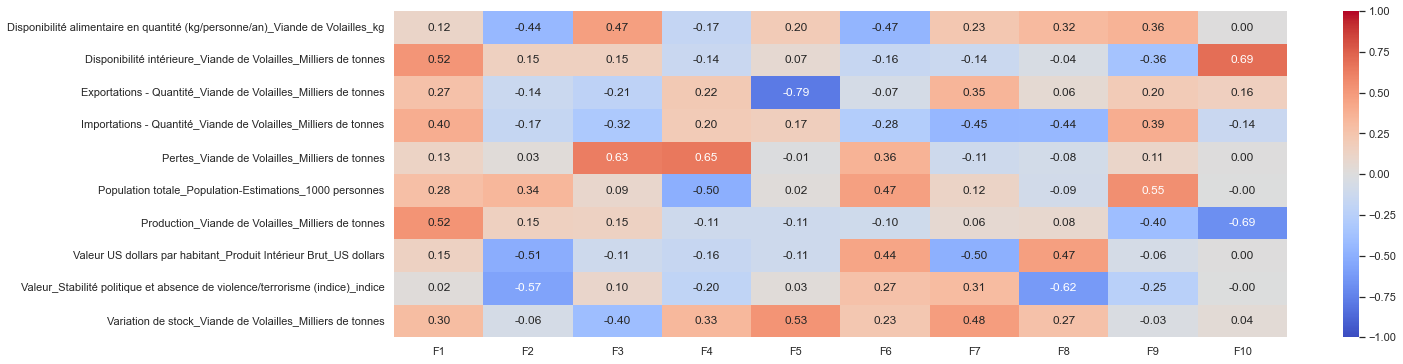

In [710]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### Visualisation Kmeans

On commence par calculer les coordonnées des centroides sur les axes des composantes de l'ACP :

In [711]:
# On utilise bien le scaler déjà entrainé pour scaler les centroides : 
centroids_proj = scaler.transform(centroids)

# Et ensuite le pca déjà entrainer pour ensuite les projeter sur les axes de nos composantes :
centroids_proj = pca.transform(centroids_proj)

# Puis j'en crée un dataframe
centroids_proj_df = pd.DataFrame(centroids_proj)

C:\Users\barba\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Puis on affiche la projection des pays et celle des centroides de nos clusters sur les axes des composantes F1 et F2 : 

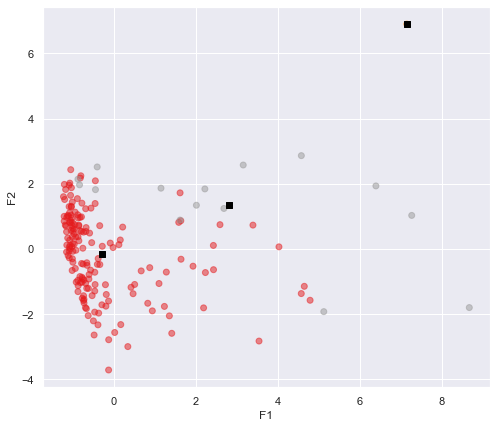

In [712]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides sous forme de carrés noirs : 
ax.scatter(centroids_proj_df.iloc[:, 0], centroids_proj_df.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

J'affiche les coordonnées des centroides des clusters dans un dataframe :

In [713]:
centroids_proj_df.index = [f"Cluster {i}" for i in range(1,n_clusters+1)]

centroids_proj_df.columns = [f"F{i}" for i in range(1,5)]

centroids_proj_df

F1        F2        F3        F4
Cluster 1 -0.297870 -0.163890  0.025332  0.050029
Cluster 2  7.150048  6.899961  2.029512 -7.136513
Cluster 3  2.819759  1.353722 -0.415641 -0.077888

J'affiche à nouveau les projections des pays et centroïdes mais cette fois sur les axes F3 et F4 :

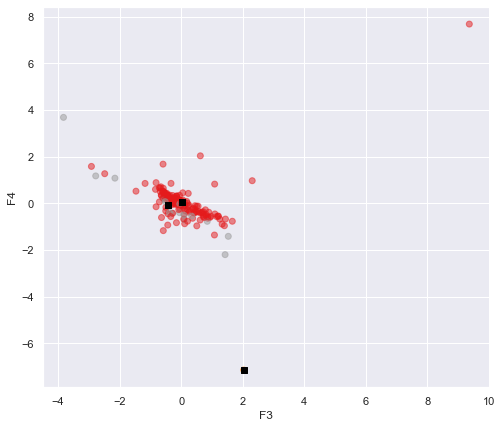

In [714]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 2], X_proj.iloc[:, 3], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides sous forme de carrés noirs : 
ax.scatter(centroids_proj_df.iloc[:, 2], centroids_proj_df.iloc[:, 3],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F3")
ax.set_ylabel("F4")
plt.show()

Et enfin, je fais un dernier affichage des projections des pays sur F1 et F2 avec mes noms des pays :

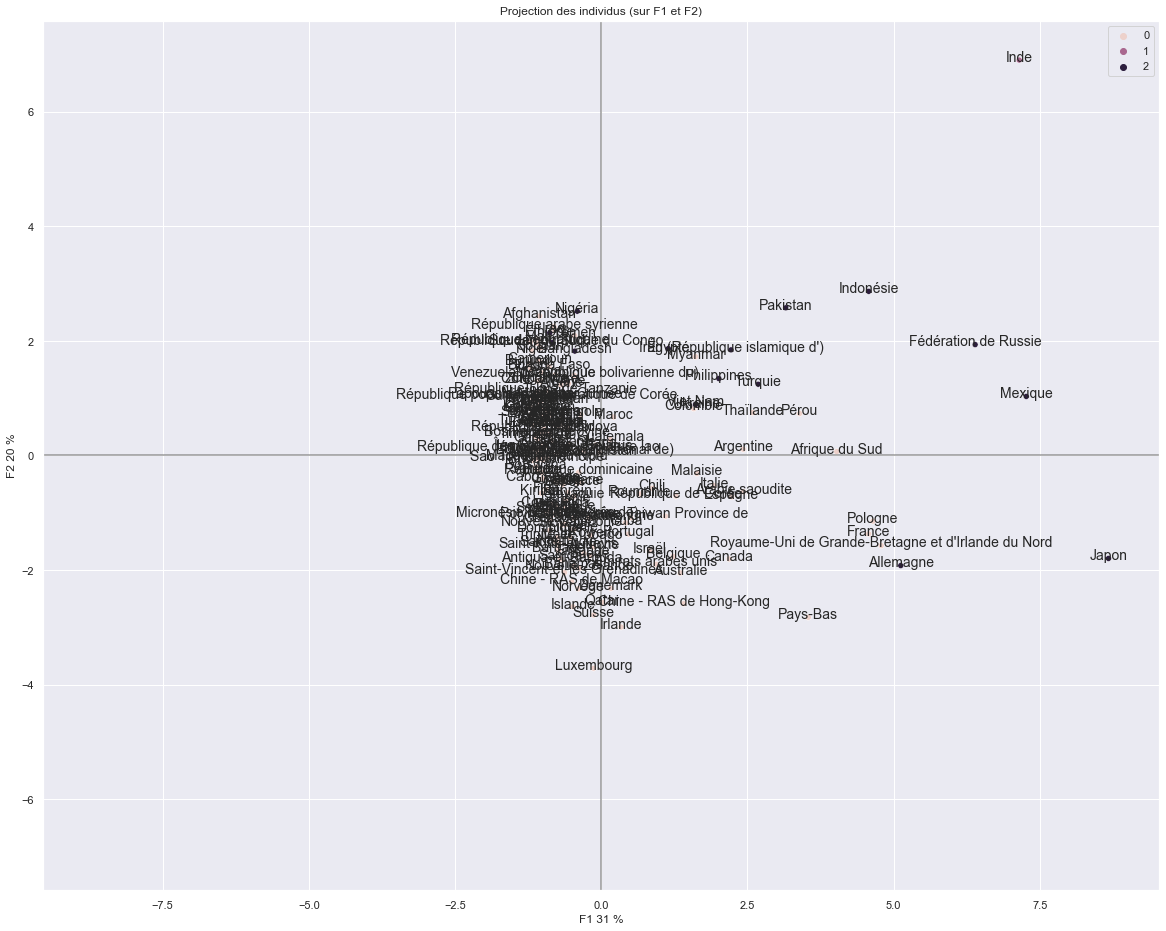

In [715]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o", clusters = labels)

### Visualisation CAH

Je calcule les barycentres des clusters obtenus par classification hierarchique : 

In [716]:
# J'ajoute une colonne contenant l'"étiquette" des clusters de la CAH dans la matrice de la projection des pays 
X_proj['cluster']= CAH

# Puis je calcule les barycentres de chaque clusters en faisant la moyenne des coordonnées de chaque cluster : 
barycentre_proj = X_proj.groupby('cluster').mean()

Puis on affiche la projection des pays et celle des centroides de nos clusters sur les axes des composantes F1 et F2 : 

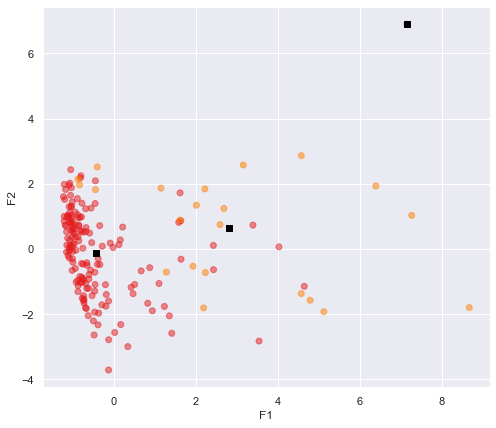

In [717]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= CAH, cmap="Set1", alpha =0.5)

# On affiche nos barycentres sous forme de carrés noirs : 
ax.scatter(barycentre_proj.iloc[:, 0], barycentre_proj.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

J'affiche les coordonnées des barycentres des clusters dans un dataframe :

In [718]:
barycentre_proj.index = [f"Cluster {i}" for i in range(1,n_clusters+1)]
barycentre_proj.columns = [f"F{i}" for i in range(1,5)]
barycentre_proj

F1        F2        F3        F4
Cluster 1 -0.434148 -0.133593  0.040301  0.047701
Cluster 2  2.812700  0.651880 -0.383520 -0.020358
Cluster 3  7.150048  6.899961  2.029512 -7.136513

J'affiche à nouveau les projections des pays et centroïdes mais cette fois sur les axes F3 et F4 :

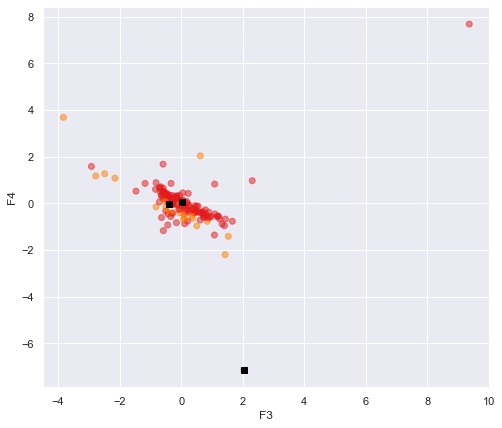

In [719]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 2], X_proj.iloc[:, 3], c= CAH, cmap="Set1", alpha =0.5)

# On affiche nos barycentres sous forme de carrés noirs : 
ax.scatter(barycentre_proj.iloc[:, 2], barycentre_proj.iloc[:, 3],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F3")
ax.set_ylabel("F4")
plt.show()

Et enfin, je fais un dernier affichage des projections des pays sur F1 et F2 avec mes noms des pays :

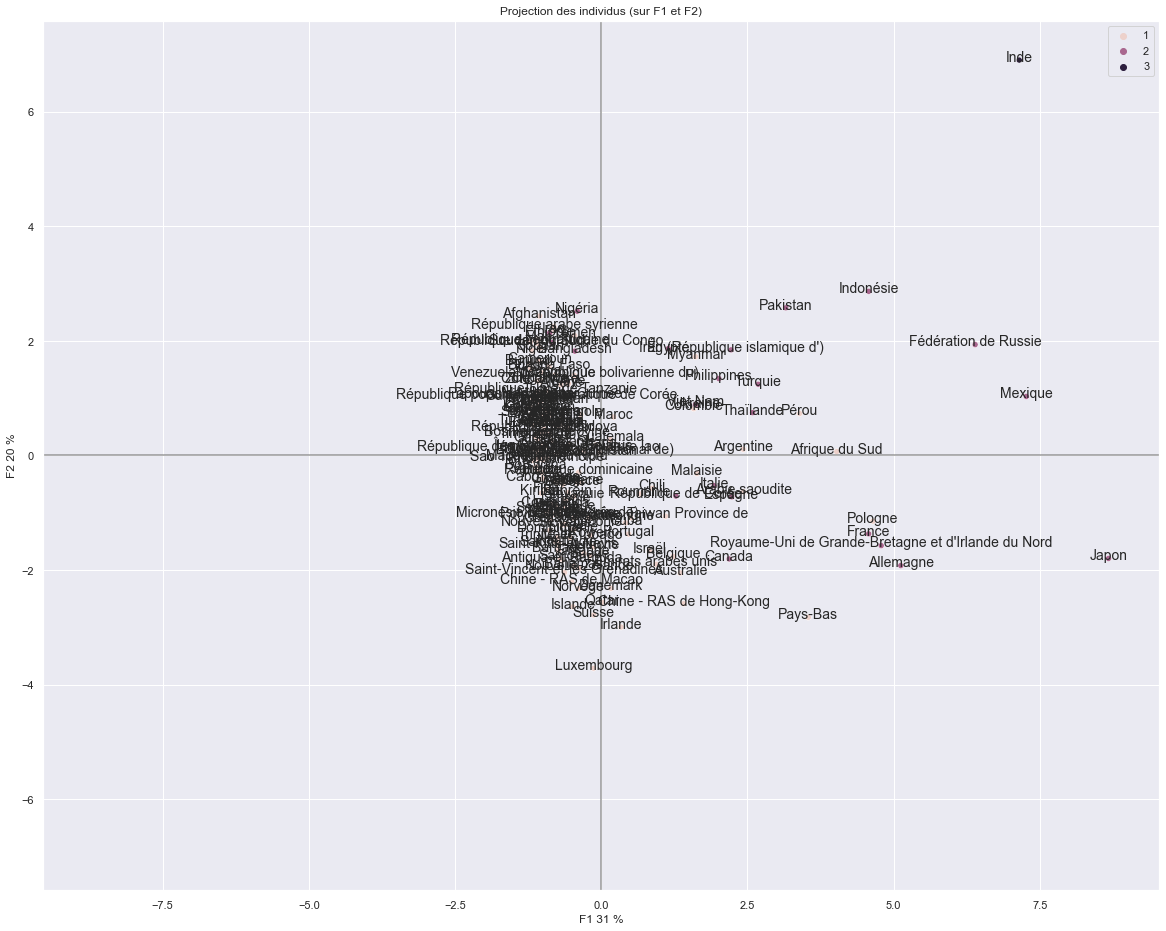

In [720]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o", clusters = CAH)

## Conclusion 

### Différences entre les méthodes de clustering

La différence entre les clusters des kmeans (cluster 3 en particulier) et les clusters de la CAH (cluster 2), réside principalement dans leur positionnement sur l'axe F2. 
Or, cet axe F2 se caractérise par une corrélation négative à trois variables d'intérêts qui sont la disponibilité en volaille, mais surtout le PIB et la stabilité politique. Je tiens donc à conserver pour la suite de mon analyse les pays qui sont placés plutôt bas sur cet axe, je vais donc préférer éliminer le cluster dont le centroide est le plus haut sur l'axe de F2

### Analyse métier

Que ce soit par la méthode des kmeans ou par classification hiérarchique, un pays forme un cluster à lui seul : L'Inde. Elle se caractérise à la fois par une disponibilité intérieure et une production de volaille élevées, et par un PIB et une stabilité politique faible. 
Il s'agit d'un outlier qui n'a en l'occurence aucun intérêt commercial pour l'exportation de volaille. L'Inde sera donc supprimée du jeu de données pour la suite de l'analyse.

Un autre petit cluster semble se détacher du reste du dataset. 
Ce cluster se caractérise lui aussi par une production importante de volaille et ne présente donc pas d'intérêt commercial. Cependant, comme expliqué lors de la comparaison des méthodes de clustering, on va préférer éliminer le cluster obtenu par les Kmeans car il ressemble des pays ayant un PIB et une stabilité politique plus faibles.

# Analyse 2

Du fait de deux clusters ayant tendance à "tirer" les résultats de notre ACP lors de notre première partie d'analyse, nous n'avons pas pou mettre en évidence des groupes de pays cibles potentielles pour l'exportation de nos poulets. 
C'est pourquoi il est intéressant ici de faire une deuxième analyse en excluant les pays de ces clusters.

## Préparation

In [799]:
df_volaille2 = df_volaille_2020.copy()

In [800]:
df_volaille2.shape

(182, 10)

In [801]:
df_volaille2['kmeans']= labels

In [802]:
df_volaille2.drop(df_volaille2[(df_volaille2['kmeans'] == 1) | (df_volaille2['kmeans'] ==2)].index, inplace = True)

In [803]:
df_volaille2.drop(['kmeans'], axis = 1, inplace = True)

In [804]:
df_volaille2.shape

(166, 10)

In [805]:
sns.set()

Dispersion des données : 

In [806]:
df_volaille2.describe()

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
count                                         166.000000                               
mean                                           22.560663                               
std                                            17.179724                               
min                                             0.480000                               
25%                                             7.185000                               
50%                                            19.995000                               
75%                                            33.175000                               
max                                            74.650000                               

       Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
count                                         166.000000                 
mean                                          276.939759                 
std                                           476.308262                 
min                                             1.000000                 
25%                                            28.250000                 
50%                                            87.500000                 
75%                                           237.250000                 
max                                          2337.000000                 

       Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
count                                         166.000000                
mean                                           48.572289                
std                                           178.723125                
min                                             0.000000                
25%                                             0.000000                
50%                                             0.000000                
75%                                             9.750000                
max                                          1361.000000                

       Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
count                                         166.000000                
mean                                           64.813253                
std                                           124.681247                
min                                             0.000000                
25%                                             3.250000                
50%                                            19.000000                
75%                                            70.250000                
max                                           766.000000                

       Pertes_Viande de Volailles_Milliers de tonnes  \
count                                     166.000000   
mean                                        3.849398   
std                                        31.227148   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                         0.000000   
max                                       389.000000   

       Population totale_Population-Estimations_1000 personnes  \
count                                         166.000000         
mean                                        14307.480036         
std                                         16709.475349         
min                                            12.315000         
25%                                          2112.714250         
50%                                          7429.481500         
75%                                         20439.955750         
max                                         71475.664000         

       Production_Viande de Volailles_Milliers de tonnes  \
count                                         166.000000   
mean       

Extaction de la matrice des données dans `X` : 

In [807]:
X = df_volaille2.values
X[:5]

array([[ 1.71000000e+00,  6.70000000e+01,  0.00000000e+00,
         3.60000000e+01,  0.00000000e+00,  3.89722300e+04,
         2.80000000e+01,  5.08453722e+02, -2.73000000e+00,
        -2.00000000e+00],
       [ 3.48600000e+01,  2.06700000e+03,  4.90000000e+01,
         4.25000000e+02,  0.00000000e+00,  5.88019270e+04,
         1.88100000e+03,  5.09438404e+03, -2.40000000e-01,
         1.89000000e+02],
       [ 1.39400000e+01,  4.00000000e+01,  0.00000000e+00,
         2.60000000e+01,  0.00000000e+00,  2.86684900e+03,
         1.40000000e+01,  5.18091420e+03,  8.00000000e-02,
         0.00000000e+00],
       [ 6.38000000e+00,  2.80000000e+02,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.34516660e+04,
         2.84000000e+02,  3.36796300e+03, -8.60000000e-01,
         3.00000000e+00],
       [ 8.41000000e+00,  2.76000000e+02,  0.00000000e+00,
         2.24000000e+02,  0.00000000e+00,  3.34284860e+04,
         5.20000000e+01,  1.89577070e+03, -5.20000000e-01,
         0.

Extraction des noms des pays dans `names` et des noms des variables dans `features` : 

In [808]:
names = df_volaille2.index
features = df_volaille2.columns

## ACP

### Standardisation des données

In [809]:
scaler = StandardScaler()

In [810]:
scaler.fit(X)

StandardScaler()

In [811]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-1.21735081e+00, -4.42098104e-01, -2.72596261e-01,
        -2.31794553e-01, -1.23643851e-01,  1.48055987e+00,
        -4.67654574e-01, -6.87052619e-01, -2.90946901e+00,
        -3.63192173e-01],
       [ 7.18087888e-01,  3.76956819e+00,  2.40038875e-03,
         2.89760153e+00, -1.23643851e-01,  2.67088427e+00,
         3.14103570e+00, -4.45871270e-01, -2.17708484e-01,
         7.01372713e+00],
       [-5.03311135e-01, -4.98955599e-01, -2.72596261e-01,
        -3.12241754e-01, -1.23643851e-01, -6.86750901e-01,
        -4.94919368e-01, -4.41320512e-01,  1.28220579e-01,
        -2.85946944e-01],
       [-9.44696250e-01,  6.44435686e-03, -2.66984084e-01,
        -5.21404474e-01, -1.23643851e-01,  1.74944860e+00,
         3.09016644e-02, -5.36666491e-01, -8.87946044e-01,
        -1.70079102e-01],
       [-8.26176172e-01, -1.97897573e-03, -2.72596261e-01,
         1.28061281e+00, -1.23643851e-01,  1.14778355e+00,
        -4.20914926e-01, -6.14091419e-01, -5.20396414e-01,
        -2.

Je vérifie que la moyenne est bien égale à 0 et l'écart type égal à 1 : 

In [812]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9
mean -0.0  0.0  0.0 -0.0  0.0 -0.0 -0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

Je m'intéresse aux 10 premières composantes : 

In [813]:
n_components = 10

In [814]:
pca = PCA(n_components=n_components)

In [815]:
pca.fit(X_scaled)

PCA(n_components=10)

On regarde maintenant le pourcentage de variance captée par chacune des composantes :

In [816]:
(pca.explained_variance_ratio_*100).round(2)

array([35.45, 20.02, 11.64,  8.4 ,  6.94,  6.21,  5.61,  4.05,  1.68,
        0.  ])

Ici la 1ère composante *capte* 35% de la variance de nos données initiales, la 2ème 20% etc etc.

In [817]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([35.45, 20.02, 11.64,  8.4 ,  6.94,  6.21,  5.61,  4.05,  1.68,
        0.  ])

On s'intéresse maintenant à la somme cumulée des variances captées par les composantes de l'ACP : 

In [818]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 35.,  55.,  67.,  76.,  82.,  89.,  94.,  98., 100., 100.])

On visualise ensuite à l'aide d'un graphique les variances captées par les 10 composantes ainsi que la somme cumulée : 

In [819]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

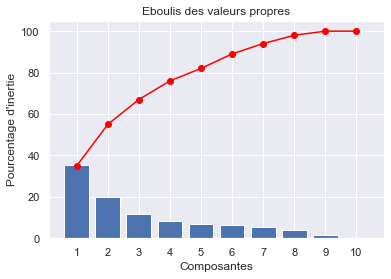

In [820]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Composantes")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.xticks(x_list)
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

On voit ici que près de 80% de la variance est comprise dans les 5 premières composantes.

Les 8 premières composantes comprennent elles plus de 95% de la variance. 

Nous calculons maintenant nos composantes et l'affichons de manière lisible : 

In [821]:
pcs = pca.components_

In [822]:
pcs = pd.DataFrame(pcs)

In [823]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

<AxesSubplot:>

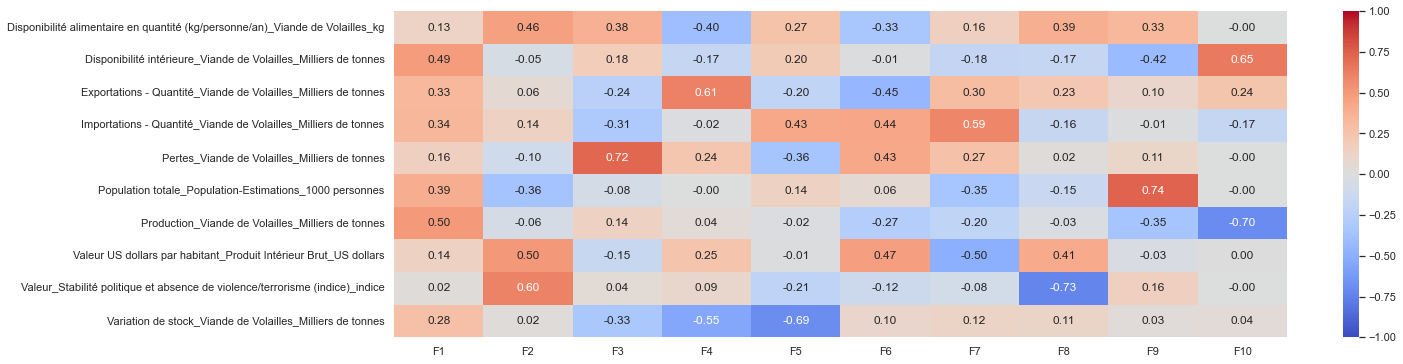

In [824]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Définissons nos axes x et y pour nos 2 premières composantes :

In [825]:
x, y = 0,1

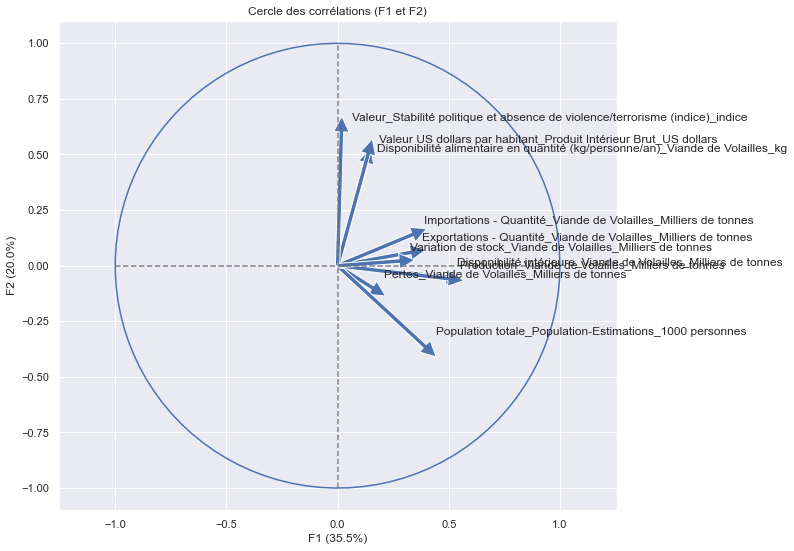

In [826]:
correlation_graph(pca, (x,y), features)

Et pour F3 et F4 :

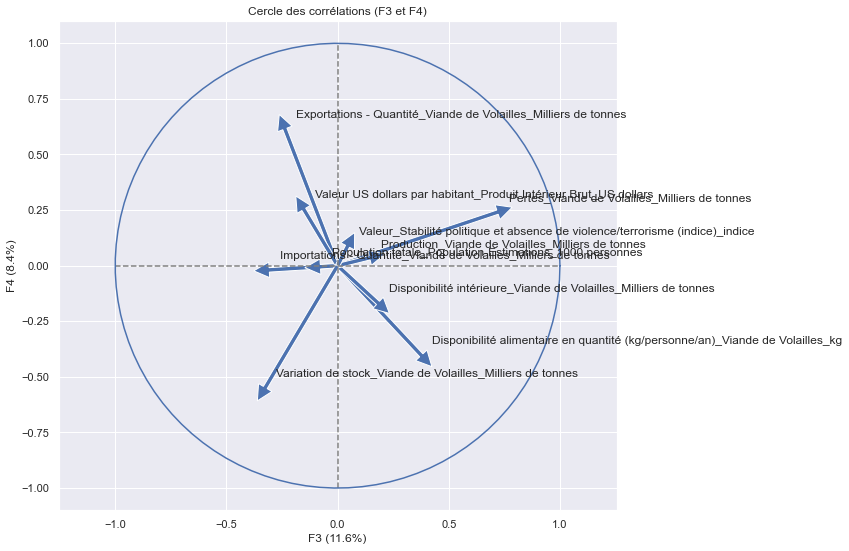

In [827]:
correlation_graph(pca, (2,3), features)

Nous voulons maintenant projeter nos pays sur les axes de nos composantes. Pour cela nous calculons les coordonnées de chaque pays les axes de chacune de nos composantes : 

In [828]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-4.57429329e-01, -3.19098088e+00, -5.81201328e-01,
         1.19804340e-01,  6.74935296e-01,  5.77886187e-01,
        -2.65383855e-01,  1.17847371e+00,  5.54948045e-01,
         1.46938776e-03],
       [ 7.38548332e+00, -8.01946465e-01, -2.00124904e+00,
        -4.87936614e+00, -2.28066751e+00,  7.57872340e-01,
         6.27804599e-01, -5.10036874e-01, -3.78404388e-01,
        -1.60510621e-03],
       [-1.17678614e+00, -1.28188691e-01, -6.09657359e-02,
         1.36624669e-01, -1.76033330e-01, -5.66650497e-02,
         2.23493112e-01, -3.23326695e-01, -2.94250070e-01,
         4.58238743e-05],
       [ 1.64003585e-01, -1.95780941e+00, -2.53392597e-01,
         6.84783998e-02,  1.79261463e-01,  8.85437689e-02,
        -8.76880646e-01, -1.96358691e-01,  8.00981734e-01,
        -2.51445161e-05],
       [ 2.82464120e-01, -1.22641217e+00, -7.15630833e-01,
         4.72366231e-02,  9.06449100e-01,  8.29387298e-01,
         5.01015053e-01, -6.46195246e-01,  6.00041879e-01,
        -5.

Projection des pays sur les axes F1 et F2 : 

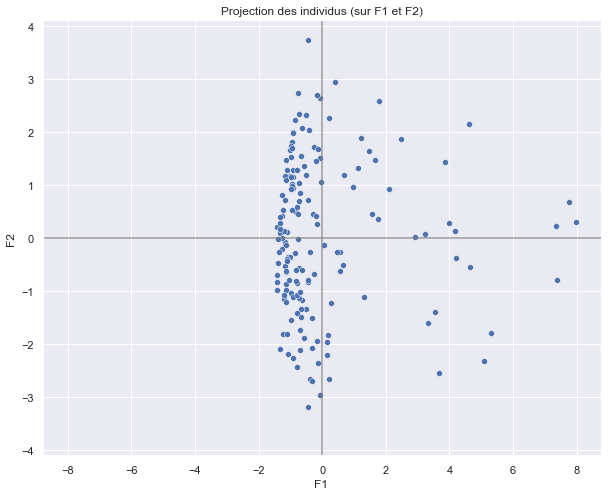

In [829]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y)

La même chose mais en affichant les noms des pays (même si seuls les pays éloignés des autres sont lisibles) : 

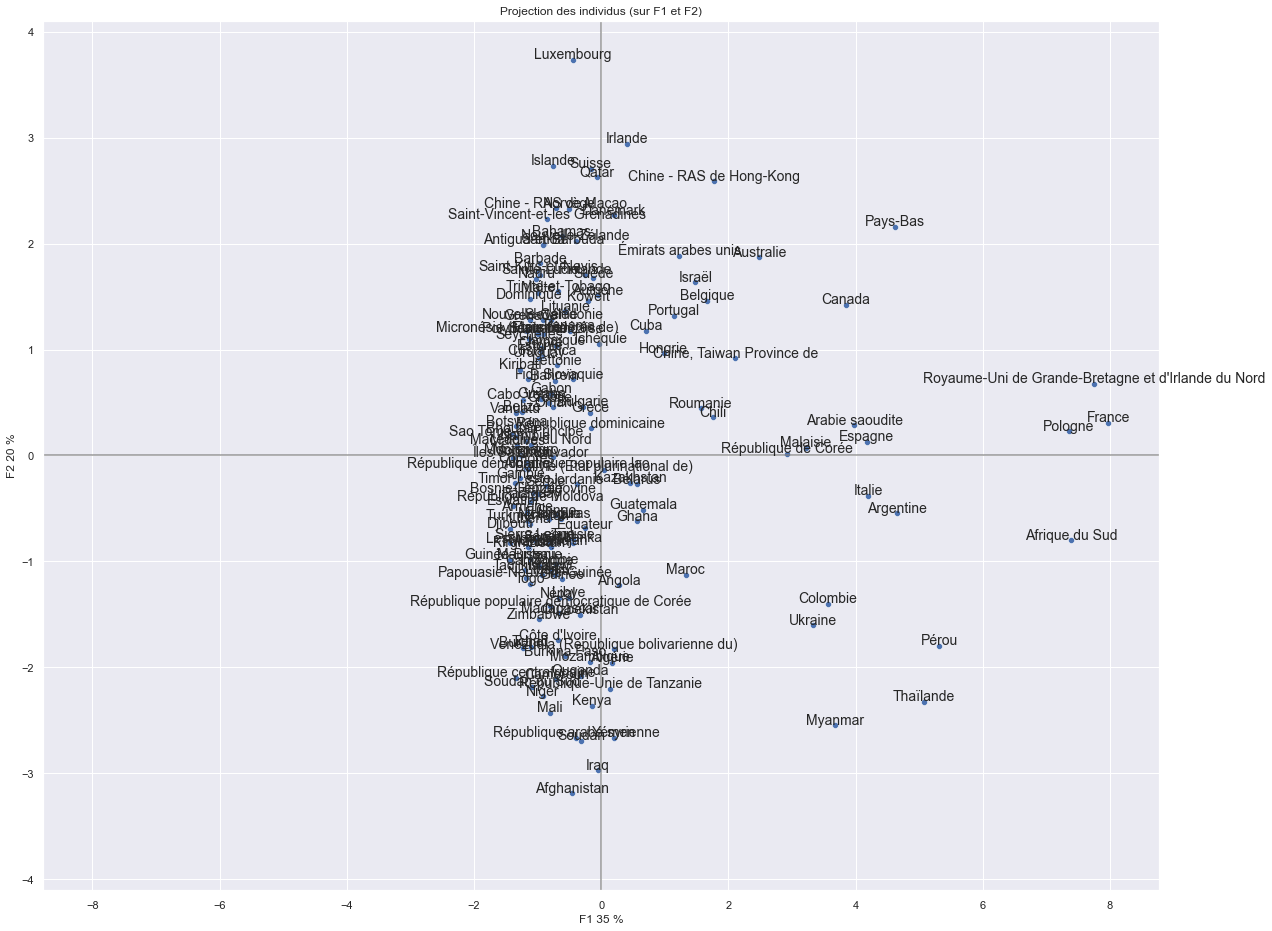

In [752]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

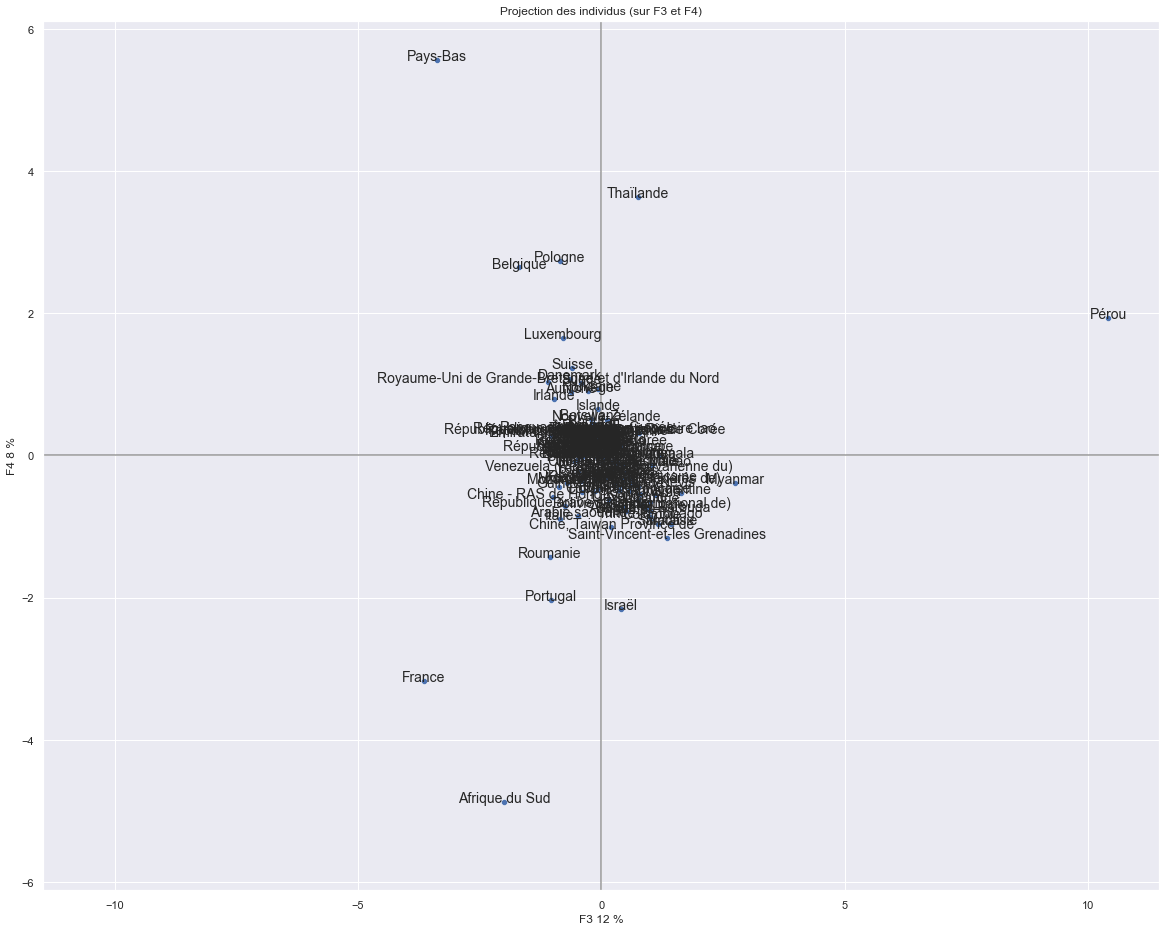

In [586]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

## Kmeans

In [587]:
df_volaille2.shape

(166, 10)

### Méthode du coude pour déterminer le nombre de clusters

In [588]:
# Une liste vide pour enregistrer les inerties :  
inertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(df_volaille2)
    
    # On enregistre l'inertie obtenue dans notre liste vide : 
    inertia_list.append(kmeans.inertia_)

C:\Users\barba\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


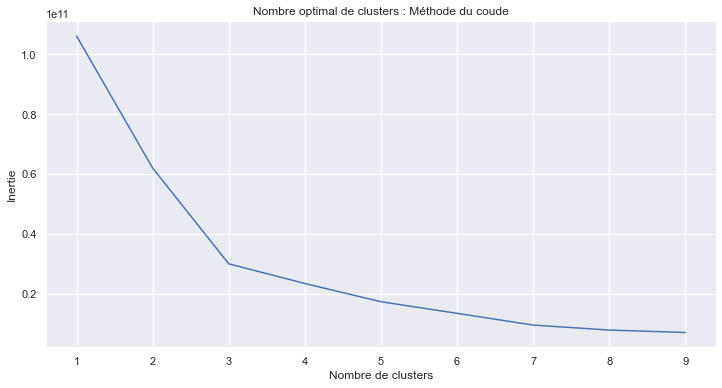

In [589]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("Inertie")
ax.set_xlabel("Nombre de clusters")
plt.title("Nombre optimal de clusters : Méthode du coude")

ax = plt.plot(k_list, inertia_list)

Le "bas" de la courbe du coude est atteint pour 7 clusters, nous allons donc faire appliquer la méthode des Kmeans avec 7 clusters.

### Clustering 

In [590]:
# On instancie notre Kmeans avec 3 clusters : 
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)

# On l'entraine : 
kmeans.fit(df_volaille2)

# On peut stocker nos clusters dans une variable labels : 
labels = kmeans.labels_
labels

array([5, 5, 3, 5, 1, 6, 5, 5, 3, 2, 2, 3, 6, 6, 6, 2, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 1, 1, 0, 1, 2, 2, 1, 6, 5, 3, 3, 3, 6, 3, 1, 2, 3,
       3, 3, 0, 6, 3, 3, 2, 0, 3, 3, 1, 3, 6, 1, 3, 3, 3, 3, 3, 3, 6, 5,
       4, 2, 2, 0, 3, 3, 1, 5, 3, 3, 6, 3, 6, 3, 3, 3, 6, 4, 3, 1, 1, 1,
       3, 1, 6, 5, 3, 3, 3, 3, 3, 1, 5, 3, 6, 3, 1, 2, 6, 2, 1, 3, 5, 1,
       3, 3, 3, 2, 5, 6, 6, 1, 2, 1, 0, 3, 1, 3, 0, 3, 3, 3, 1, 5, 6, 3,
       3, 3, 3, 3, 3, 3, 6, 6, 5, 3, 1, 4, 3, 2, 1, 3, 1, 6, 5, 3, 3, 6,
       3, 3, 5, 6, 3, 1, 1, 1, 1, 2, 1, 3])

J'ajoute dans mon dataframe une colonne correspondant au cluster attribué à chaque pays par cette méthode :

In [591]:
df_volaille2['kmeans']= labels

J'affiche la liste de pays de chaque cluster si le nombre de pays est inférieur à 20 (pour plus de lisibilité) :

In [592]:
if df_volaille2.loc[df_volaille2['kmeans']==0].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==0]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                                                
Canada                                                                                          40.10                               
Espagne                                                                                         33.60                               
France                                                                                          22.97                               
Italie                                                                                          19.62                               
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                              32.73                               
République de Corée                                                                             22.76                               

                                                    Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                  
Canada                                                                                           1510                 
Espagne                                                                                          1584                 
France                                                                                           1582                 
Italie                                                                                           1215                 
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                               2337                 
République de Corée                                                                              1167                 

                                                    Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                 
Canada                                                                                            155                
Espagne                                                                                           227                
France                                                                                            375                
Italie                                                                                            178                
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                                429                
République de Corée                                                                                56                

                                                    Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                 
Canada                                                                                            195                
Espagne                                                                                           179                
France                                                                                            516                
Italie                                                                                             84                
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                                766                
République de Corée                                                                               176                

                                                    Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                       

In [593]:
if df_volaille2.loc[df_volaille2['kmeans']==1].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==1]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [594]:
if df_volaille2.loc[df_volaille2['kmeans']==2].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==2]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                      
Australie                                                             48.73                               
Autriche                                                              15.66                               
Belgique                                                              12.44                               
Chine - RAS de Hong-Kong                                              55.52                               
Chine - RAS de Macao                                                  45.56                               
Danemark                                                              24.56                               
Finlande                                                              21.08                               
Islande                                                               30.03                               
Israël                                                                68.93                               
Norvège                                                               19.99                               
Nouvelle-Zélande                                                      25.99                               
Pays-Bas                                                               9.99                               
Qatar                                                                 54.28                               
Suède                                                                 15.40                               
Émirats arabes unis                                                   31.14                               

                          Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                        
Australie                                                              1243                 
Autriche                                                                156                 
Belgique                                                                182                 
Chine - RAS de Hong-Kong                                                465                 
Chine - RAS de Macao                                                     30                 
Danemark                                                                143                 
Finlande                                                                125                 
Islande                                                                  10                 
Israël                                                                  598                 
Norvège                                                                 110                 
Nouvelle-Zélande                                                        207                 
Pays-Bas                                                                214                 
Qatar                                                                   163                 
Suède                                                                   215                 
Émirats arabes unis                                                     459                 

                          Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                       
Australie                                                                42                
Autriche                                                                 83                
Belgique                                                                567                
Chine - RAS de Hong-Kong                                                 90                
Chine - RAS de Macao                                                    

In [595]:
if df_volaille2.loc[df_volaille2['kmeans']==3].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==3]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [596]:
if df_volaille2.loc[df_volaille2['kmeans']==4].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==4]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                        
Irlande                                                 24.72                               
Luxembourg                                              18.09                               
Suisse                                                  16.89                               

            Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                          
Irlande                                                   129                 
Luxembourg                                                 11                 
Suisse                                                    146                 

            Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                         
Irlande                                                    96                
Luxembourg                                                  1                
Suisse                                                      1                

            Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                         
Irlande                                                    85                
Luxembourg                                                 13                
Suisse                                                     42                

            Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                        
Irlande                                                 0   
Luxembourg                                              0   
Suisse                                                  0   

            Population totale_Population-Estimations_1000 personnes  \
Zone                                                                  
Irlande                                              4946.119         
Luxembourg                                            630.399         
Suisse                                               8638.613         

            Production_Viande de Volailles_Milliers de tonnes  \
Zone                                                            
Irlande                                                   166   
Luxembourg                                                  0   
Suisse                                                    106   

            Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
Zone                                                                           
Irlande                                          86250.994153                  
Luxembourg                                      117181.646629                  
Suisse                                           86918.648293                  

            Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice  \
Zone                                                                                       
Irlande                                                  0.98                              
Luxembourg                                               1.23                              
Suisse                                                   1.19                              

            Variation de stock_Viande de Volailles_Milliers de tonnes  kmeans  
Zone                                                                           
Irlande                                                    26               4  
Luxembourg                                                  0               4  
Suisse                                                      0               4

In [597]:
if df_volaille2.loc[df_volaille2['kmeans']==5].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==5]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                         
Afghanistan                                                               1.71                               
Afrique du Sud                                                           34.86                               
Algérie                                                                   6.38                               
Arabie saoudite                                                          42.96                               
Argentine                                                                46.23                               
Colombie                                                                 33.78                               
Iraq                                                                      5.38                               
Kenya                                                                     1.31                               
Maroc                                                                    23.99                               
Myanmar                                                                  29.85                               
Ouganda                                                                   1.52                               
Pologne                                                                  32.89                               
République-Unie de Tanzanie                                               1.49                               
Soudan                                                                    1.85                               
Thaïlande                                                                11.40                               
Ukraine                                                                  24.85                               

                             Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                           
Afghanistan                                                                 67                 
Afrique du Sud                                                            2067                 
Algérie                                                                    280                 
Arabie saoudite                                                           1495                 
Argentine                                                                 2089                 
Colombie                                                                  1719                 
Iraq                                                                       185                 
Kenya                                                                       71                 
Maroc                                                                      885                 
Myanmar                                                                   1692                 
Ouganda                                                                     70                 
Pologne                                                                   1335                 
République-Unie de Tanzanie                                                 89                 
Soudan                                                                      81                 
Thaïlande                                                                  927                 
Ukraine                                                                   1089                 

                             Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                          
Afghanistan                                                                  0                
Afrique du Sud                    

In [598]:
if df_volaille2.loc[df_volaille2['kmeans']==6].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['kmeans']==6]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

Je stocke les centroïdes des clusters dans une variable `centroids`:

In [599]:
centroids = kmeans.cluster_centers_
centroids

array([[ 2.86300000e+01,  1.56583333e+03,  2.36666667e+02,
         3.19333333e+02,  4.44089210e-16,  5.46895513e+04,
         1.52866667e+03,  3.56383668e+04,  5.48333333e-01,
         4.56666667e+01],
       [ 1.28060000e+01,  3.29300000e+02,  1.14333333e+01,
         5.98333333e+01,  1.43666667e+01,  2.41283884e+04,
         2.88300000e+02,  3.52589951e+03, -6.91000000e-01,
         7.46666667e+00],
       [ 3.19533333e+01,  2.88000000e+02,  1.62400000e+02,
         1.59666667e+02,  4.66666667e-01,  8.33921500e+03,
         2.98066667e+02,  5.05821209e+04,  7.92000000e-01,
         7.53333333e+00],
       [ 2.07227397e+01,  7.91917808e+01,  4.35616438e+00,
         2.93150685e+01,  2.32876712e-01,  4.77761160e+03,
         5.59041096e+01,  4.44077764e+03, -4.39726027e-02,
         1.60273973e+00],
       [ 1.99000000e+01,  9.53333333e+01,  3.26666667e+01,
         4.66666667e+01,  0.00000000e+00,  4.73837700e+03,
         9.06666667e+01,  9.67837630e+04,  1.13333333e+00,
         8.

## Clustering hierarchique

In [830]:
Z = linkage(df_volaille2, method="ward")

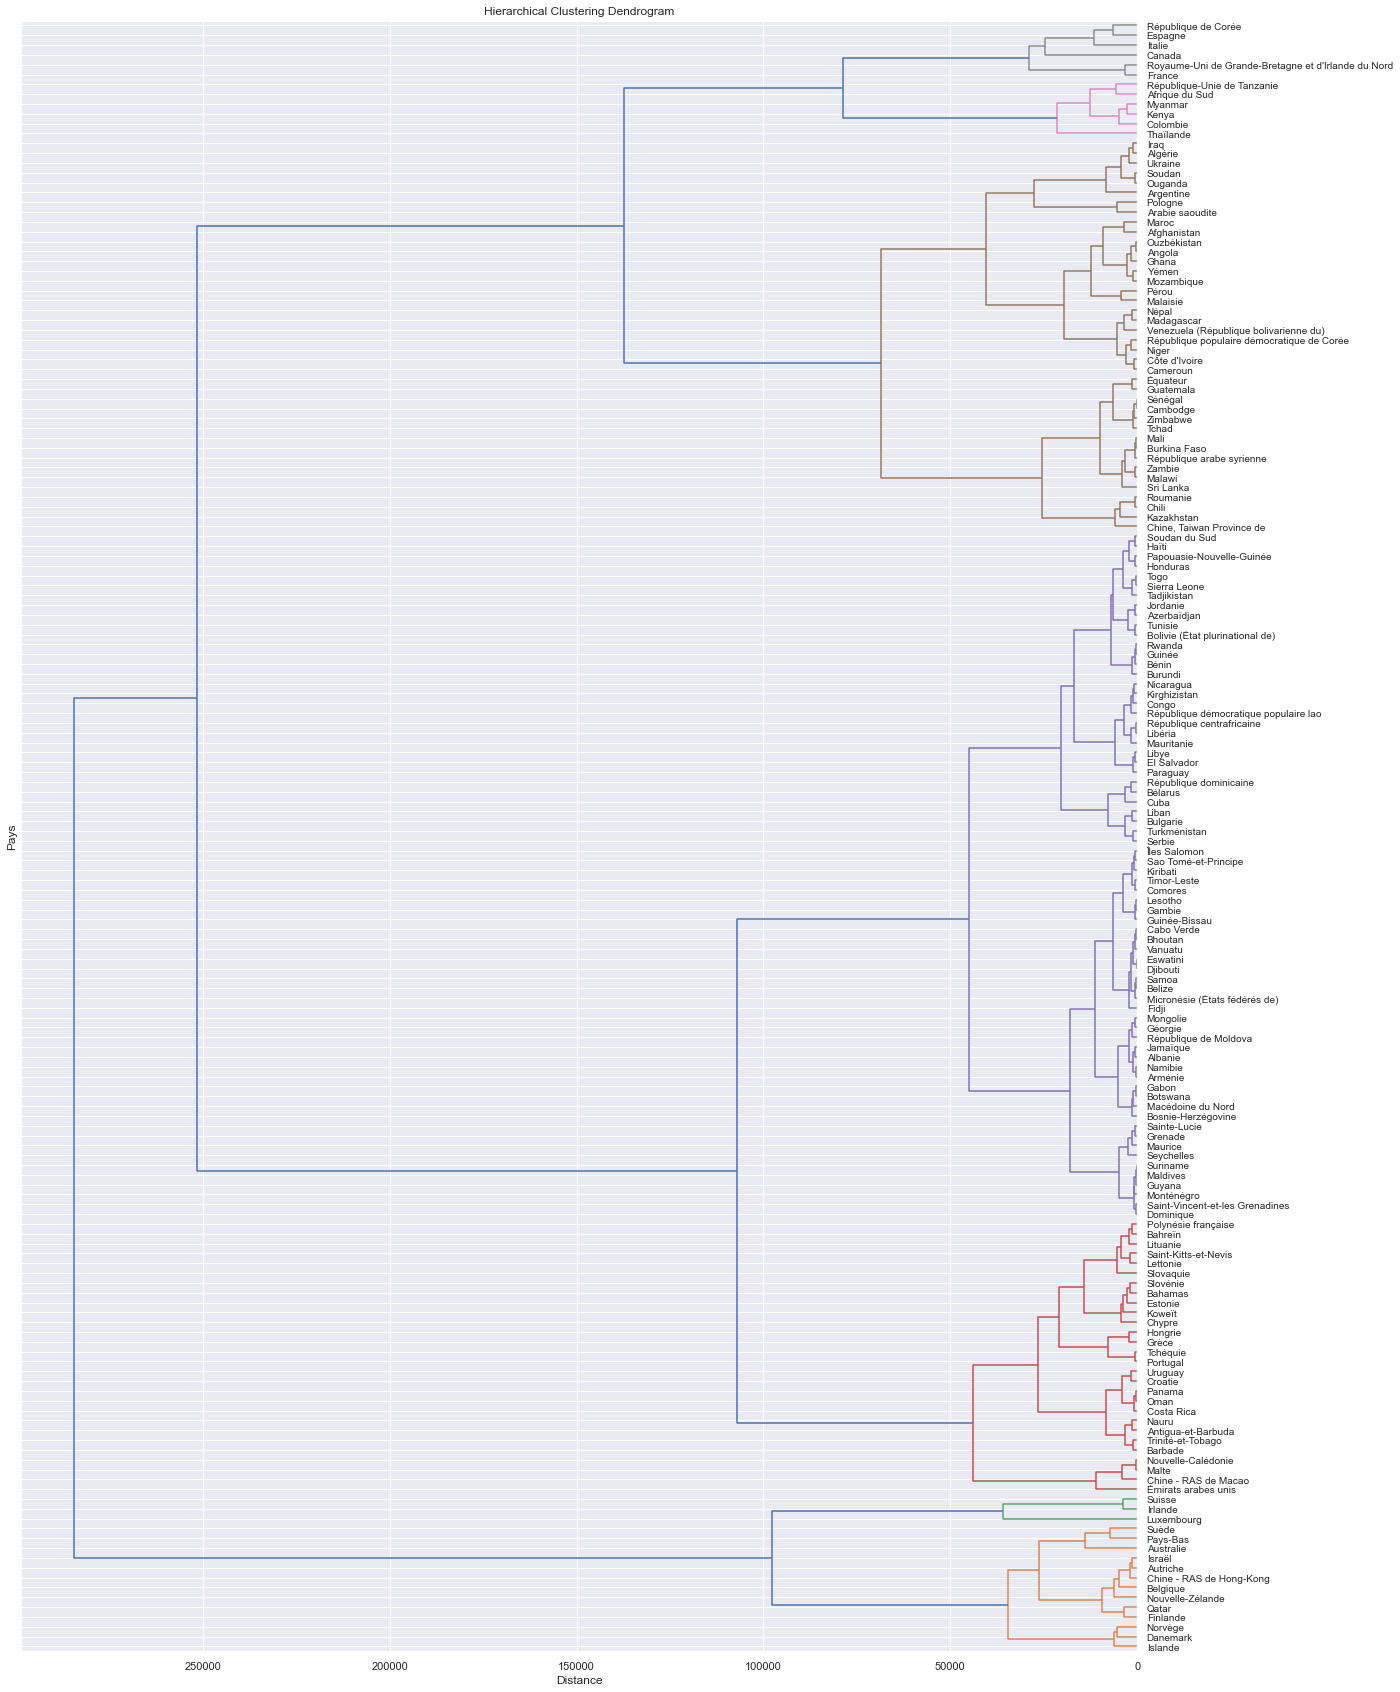

In [831]:
fig, ax = plt.subplots(1, 1, figsize=(20, 30))

dendrogram(Z,  ax=ax, orientation = 'left', labels = names, leaf_font_size = 10, color_threshold = 70000)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Pays")
plt.xlabel("Distance")
plt.show()

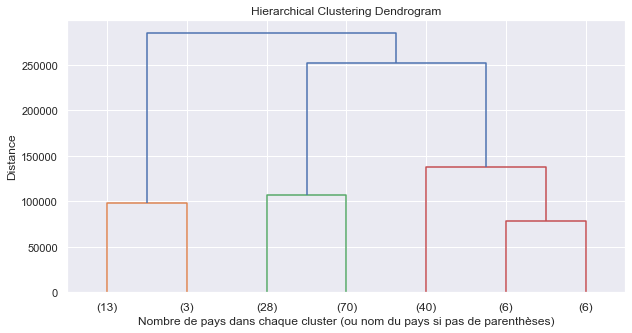

In [832]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

_ = dendrogram(Z, p=7, truncate_mode="lastp", ax=ax, labels = names)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nombre de pays dans chaque cluster (ou nom du pays si pas de parenthèses)")
plt.ylabel("Distance")
plt.show()

In [602]:
CAH = fcluster(Z,t =n_clusters, criterion ='maxclust')
print(CAH)

[5 6 4 5 5 3 5 5 4 1 1 4 3 3 3 1 4 4 4 4 4 4 5 4 4 4 4 5 5 7 5 1 3 5 3 6 4
 4 3 3 4 5 1 4 4 4 7 3 4 4 1 7 4 4 5 4 3 5 4 4 4 4 4 4 3 5 2 1 1 7 4 4 5 6
 4 4 3 4 3 4 4 4 3 2 4 5 5 5 4 5 3 5 4 4 4 4 4 5 6 4 3 4 5 1 3 1 5 3 5 5 3
 4 4 1 5 3 3 5 1 5 7 4 5 4 7 4 4 4 5 6 3 4 4 4 4 4 4 4 3 3 5 4 5 2 4 1 5 4
 5 3 6 4 4 3 4 4 5 3 4 5 5 5 5 3 5 4]


J'ajoute dans mon dataframe une colonne correspondant au cluster attribué à chaque pays par cette méthode :

In [603]:
df_volaille2['CAH']= CAH

J'affiche la liste de pays de chaque cluster si le nombre de pays est inférieur à 20 (pour plus de lisibilité) :

In [604]:
if df_volaille2.loc[df_volaille2['CAH']==1].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==1]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                      
Australie                                                             48.73                               
Autriche                                                              15.66                               
Belgique                                                              12.44                               
Chine - RAS de Hong-Kong                                              55.52                               
Danemark                                                              24.56                               
Finlande                                                              21.08                               
Islande                                                               30.03                               
Israël                                                                68.93                               
Norvège                                                               19.99                               
Nouvelle-Zélande                                                      25.99                               
Pays-Bas                                                               9.99                               
Qatar                                                                 54.28                               
Suède                                                                 15.40                               

                          Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                        
Australie                                                              1243                 
Autriche                                                                156                 
Belgique                                                                182                 
Chine - RAS de Hong-Kong                                                465                 
Danemark                                                                143                 
Finlande                                                                125                 
Islande                                                                  10                 
Israël                                                                  598                 
Norvège                                                                 110                 
Nouvelle-Zélande                                                        207                 
Pays-Bas                                                                214                 
Qatar                                                                   163                 
Suède                                                                   215                 

                          Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                       
Australie                                                                42                
Autriche                                                                 83                
Belgique                                                                567                
Chine - RAS de Hong-Kong                                                 90                
Danemark                                                                139                
Finlande                                                                 12                
Islande                                                                   0                
Israël                                                                    4                
Norvège                                                                   0                
Nouvelle-Zél

In [605]:
if df_volaille2.loc[df_volaille2['CAH']==2].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==2]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                        
Irlande                                                 24.72                               
Luxembourg                                              18.09                               
Suisse                                                  16.89                               

            Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                          
Irlande                                                   129                 
Luxembourg                                                 11                 
Suisse                                                    146                 

            Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                         
Irlande                                                    96                
Luxembourg                                                  1                
Suisse                                                      1                

            Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                         
Irlande                                                    85                
Luxembourg                                                 13                
Suisse                                                     42                

            Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                        
Irlande                                                 0   
Luxembourg                                              0   
Suisse                                                  0   

            Population totale_Population-Estimations_1000 personnes  \
Zone                                                                  
Irlande                                              4946.119         
Luxembourg                                            630.399         
Suisse                                               8638.613         

            Production_Viande de Volailles_Milliers de tonnes  \
Zone                                                            
Irlande                                                   166   
Luxembourg                                                  0   
Suisse                                                    106   

            Valeur US dollars par habitant_Produit Intérieur Brut_US dollars  \
Zone                                                                           
Irlande                                          86250.994153                  
Luxembourg                                      117181.646629                  
Suisse                                           86918.648293                  

            Valeur_Stabilité politique et absence de violence/terrorisme (indice)_indice  \
Zone                                                                                       
Irlande                                                  0.98                              
Luxembourg                                               1.23                              
Suisse                                                   1.19                              

            Variation de stock_Viande de Volailles_Milliers de tonnes  kmeans  \
Zone                                                                            
Irlande                                                    26               4   
Luxembourg                                                  0               4   
Suisse                                                      0               4   

            CAH  
Zone             
Irlande       2  
Luxembourg    2  
Suisse        2

In [606]:
if df_volaille2.loc[df_volaille2['CAH']==3].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==3]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [607]:
if df_volaille2.loc[df_volaille2['CAH']==4].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==4]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [608]:
if df_volaille2.loc[df_volaille2['CAH']==5].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==5]
else:
    x = "Le cluster contient trop de pays"
x

'Le cluster contient trop de pays'

In [609]:
if df_volaille2.loc[df_volaille2['CAH']==6].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==6]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                         
Afrique du Sud                                                           34.86                               
Colombie                                                                 33.78                               
Kenya                                                                     1.31                               
Myanmar                                                                  29.85                               
République-Unie de Tanzanie                                               1.49                               
Thaïlande                                                                11.40                               

                             Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                           
Afrique du Sud                                                            2067                 
Colombie                                                                  1719                 
Kenya                                                                       71                 
Myanmar                                                                   1692                 
République-Unie de Tanzanie                                                 89                 
Thaïlande                                                                  927                 

                             Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                          
Afrique du Sud                                                              49                
Colombie                                                                     0                
Kenya                                                                        0                
Myanmar                                                                      0                
République-Unie de Tanzanie                                                  0                
Thaïlande                                                                  918                

                             Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                          
Afrique du Sud                                                             425                
Colombie                                                                    98                
Kenya                                                                        1                
Myanmar                                                                      1                
République-Unie de Tanzanie                                                  7                
Thaïlande                                                                    2                

                             Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                                                         
Afrique du Sud                                                           0   
Colombie                                                                 0   
Kenya                                                                    0   
Myanmar                                                                 68   
République-Unie de Tanzanie                                              0   
Thaïlande                                                               67   

                             Population totale_Population-Estimations_1000 personnes  \
Zone                                                                                   
Afrique du Sud                                          

In [610]:
if df_volaille2.loc[df_volaille2['CAH']==7].shape < (20,10) :
    x= df_volaille2.loc[df_volaille2['CAH']==7]
else:
    x = "Le cluster contient trop de pays"
x

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                                                
Canada                                                                                          40.10                               
Espagne                                                                                         33.60                               
France                                                                                          22.97                               
Italie                                                                                          19.62                               
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                              32.73                               
République de Corée                                                                             22.76                               

                                                    Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                  
Canada                                                                                           1510                 
Espagne                                                                                          1584                 
France                                                                                           1582                 
Italie                                                                                           1215                 
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                               2337                 
République de Corée                                                                              1167                 

                                                    Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                 
Canada                                                                                            155                
Espagne                                                                                           227                
France                                                                                            375                
Italie                                                                                            178                
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                                429                
République de Corée                                                                                56                

                                                    Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                                                 
Canada                                                                                            195                
Espagne                                                                                           179                
France                                                                                            516                
Italie                                                                                             84                
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                                766                
République de Corée                                                                               176                

                                                    Pertes_Viande de Volailles_Milliers de tonnes  \
Zone                                       

## ACP pour visualisation

In [611]:
df_volaille2.drop(columns = ["kmeans",'CAH'], inplace = True)

In [612]:
df_volaille2

Disponibilité alimentaire en quantité (kg/personne/an)_Viande de Volailles_kg  \
Zone                                                                                                 
Afghanistan                                                       1.71                               
Afrique du Sud                                                   34.86                               
Albanie                                                          13.94                               
Algérie                                                           6.38                               
Angola                                                            8.41                               
...                                                                ...                               
Zambie                                                            2.64                               
Zimbabwe                                                          4.62                               
Émirats arabes unis                                              31.14                               
Équateur                                                         18.88                               
Îles Salomon                                                      6.14                               

                     Disponibilité intérieure_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                   
Afghanistan                                                         67                 
Afrique du Sud                                                    2067                 
Albanie                                                             40                 
Algérie                                                            280                 
Angola                                                             276                 
...                                                                ...                 
Zambie                                                              49                 
Zimbabwe                                                            69                 
Émirats arabes unis                                                459                 
Équateur                                                           333                 
Îles Salomon                                                         4                 

                     Exportations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                  
Afghanistan                                                          0                
Afrique du Sud                                                      49                
Albanie                                                              0                
Algérie                                                              1                
Angola                                                               0                
...                                                                ...                
Zambie                                                               9                
Zimbabwe                                                             0                
Émirats arabes unis                                                 86                
Équateur                                                             0                
Îles Salomon                                                         0                

                     Importations - Quantité_Viande de Volailles_Milliers de tonnes  \
Zone                                                                                  
Afghanistan                                                         36                
Afrique du Sud                                                     425                
Albanie                                                             2

Je commence par scaler les données :

In [613]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_volaille2)

J'instancie et je fit :

In [614]:
pca = PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

Puis je transforme :

In [615]:
X_proj = pca.transform(X_scaled)

#Je transforme en dataframe en renommant les colonnes aux noms des mes composantes
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3",'PC4'])
X_proj[:10]

PC1       PC2       PC3       PC4
0 -0.457429 -3.190981 -0.581201  0.119804
1  7.385483 -0.801946 -2.001249 -4.879366
2 -1.176786 -0.128189 -0.060966  0.136625
3  0.164004 -1.957809 -0.253393  0.068478
4  0.282464 -1.226412 -0.715631  0.047237
5 -0.905384  1.993176  1.006326 -0.776345
6  3.976752  0.285775 -0.469332 -0.849379
7  4.657118 -0.547134  1.647543 -0.530724
8 -1.163508 -0.530027 -0.070759  0.028188
9  2.483649  1.870957  1.050083 -0.129274

Je réaffiche la heatmap de corrélation de nos variables avec nos 10 composantes afin de mieux comprendre les résultats :

<AxesSubplot:>

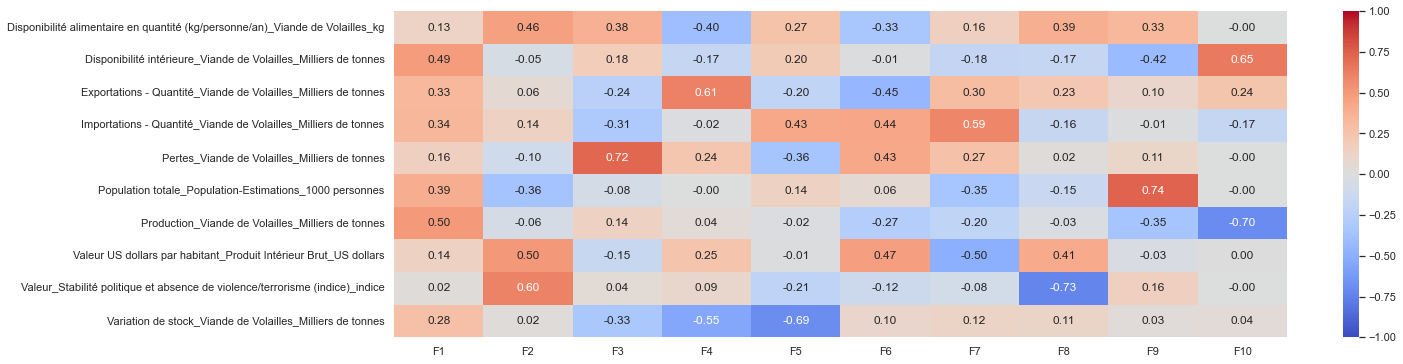

In [616]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### Visualisation Kmeans

On commence par calculer les coordonnées des centroides sur les axes des composantes de l'ACP :

In [617]:
# On utilise bien le scaler déjà entrainé pour scaler les centroides : 
centroids_proj = scaler.transform(centroids)

# Et ensuite le pca déjà entrainer pour ensuite les projeter sur les axes de nos composantes :
centroids_proj = pca.transform(centroids_proj)

# Puis j'en crée un dataframe
centroids_proj_df = pd.DataFrame(centroids_proj)

C:\Users\barba\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Puis on affiche la projection des pays et celle des centroides de nos clusters sur les axes des composantes F1 et F2 : 

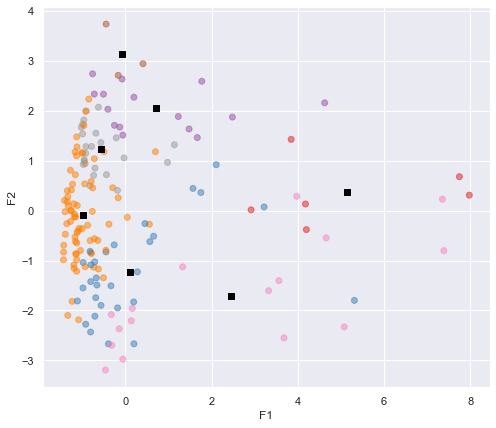

In [618]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides sous forme de carrés noirs : 
ax.scatter(centroids_proj_df.iloc[:, 0], centroids_proj_df.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

J'affiche les coordonnées des centroides des clusters dans un dataframe :

In [619]:
centroids_proj_df.index = [f"Cluster {i}" for i in range(1,n_clusters+1)]

centroids_proj_df.columns = [f"F{i}" for i in range(1,5)]

centroids_proj_df

F1        F2        F3        F4
Cluster 1  5.143858  0.362585 -0.803991 -0.401404
Cluster 2  0.118252 -1.226786  0.118278 -0.032970
Cluster 3  0.705016  2.053740 -0.474420  0.699492
Cluster 4 -0.972011 -0.089912  0.077186 -0.073549
Cluster 5 -0.065275  3.125954 -0.780083  1.227242
Cluster 6  2.459856 -1.707164  0.010461  0.038359
Cluster 7 -0.573522  1.231404  0.214356 -0.261792

J'affiche à nouveau les projections des pays et centroïdes mais cette fois sur les axes F3 et F4 :

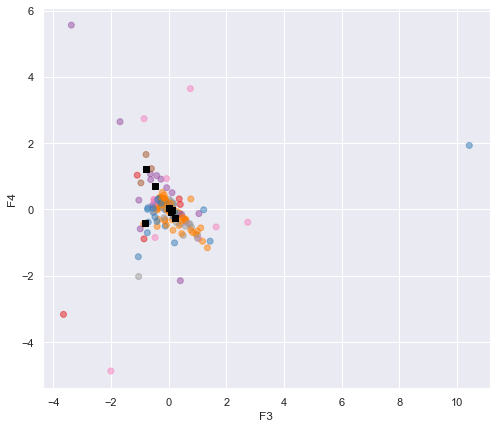

In [620]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 2], X_proj.iloc[:, 3], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides sous forme de carrés noirs : 
ax.scatter(centroids_proj_df.iloc[:, 2], centroids_proj_df.iloc[:, 3],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F3")
ax.set_ylabel("F4")
plt.show()

Et enfin, je fais un dernier affichage des projections des pays sur F1 et F2 avec mes noms des pays :

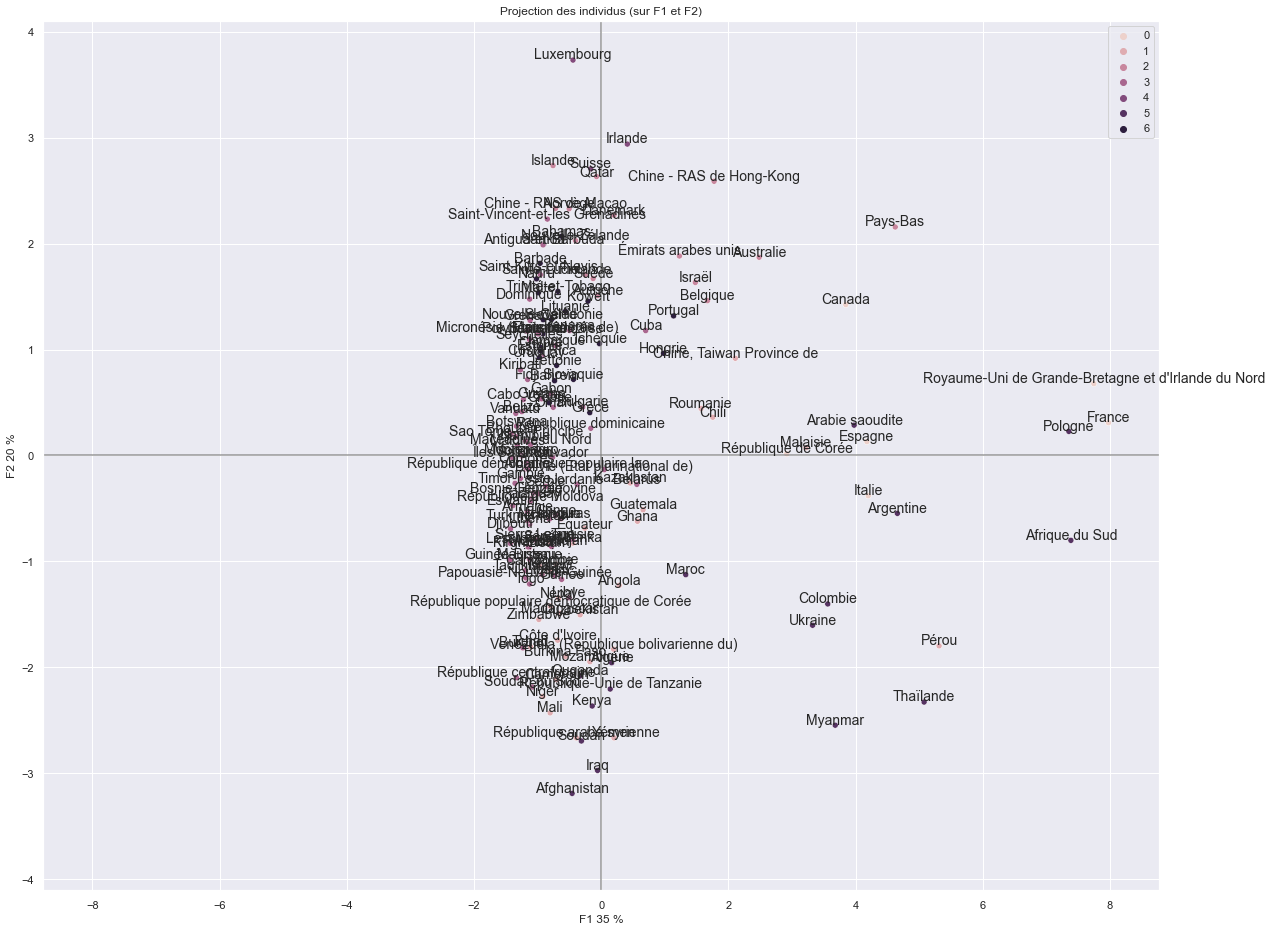

In [621]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o", clusters = labels)

### Visualisation CAH

Je calcule les barycentres des clusters obtenus par classification hierarchique : 

In [622]:
# J'ajoute une colonne contenant l'"étiquette" des clusters de la CAH dans la matrice de la projection des pays 
X_proj['cluster']= CAH

# Puis je calcule les barycentres de chaque clusters en faisant la moyenne des coordonnées de chaque cluster : 
barycentre_proj = X_proj.groupby('cluster').mean()

Puis on affiche la projection des pays et celle des centroides de nos clusters sur les axes des composantes F1 et F2 : 

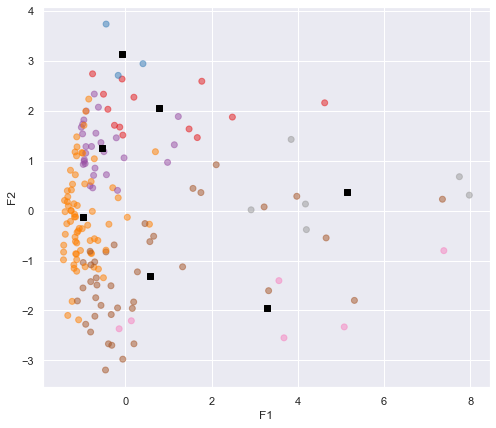

In [623]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= CAH, cmap="Set1", alpha =0.5)

# On affiche nos barycentres sous forme de carrés noirs : 
ax.scatter(barycentre_proj.iloc[:, 0], barycentre_proj.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

J'affiche les coordonnées des barycentres des clusters dans un dataframe :

In [624]:
barycentre_proj.index = [f"Cluster {i}" for i in range(1,n_clusters+1)]
barycentre_proj.columns = [f"F{i}" for i in range(1,5)]
barycentre_proj

F1        F2        F3        F4
Cluster 1  0.774072  2.045487 -0.497640  0.796363
Cluster 2 -0.065275  3.125954 -0.780083  1.227242
Cluster 3 -0.530615  1.253972  0.214287 -0.214317
Cluster 4 -0.982547 -0.130539  0.055968 -0.074997
Cluster 5  0.580021 -1.311673  0.054857  0.039060
Cluster 6  3.284068 -1.941882  0.253570 -0.322959
Cluster 7  5.143858  0.362585 -0.803991 -0.401404

J'affiche à nouveau les projections des pays et centroïdes mais cette fois sur les axes F3 et F4 :

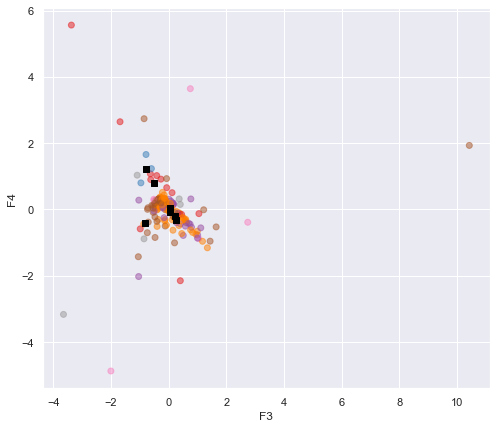

In [625]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 2], X_proj.iloc[:, 3], c= CAH, cmap="Set1", alpha =0.5)

# On affiche nos barycentres sous forme de carrés noirs : 
ax.scatter(barycentre_proj.iloc[:, 2], barycentre_proj.iloc[:, 3],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F3")
ax.set_ylabel("F4")
plt.show()

Et enfin, je fais un dernier affichage des projections des pays sur F1 et F2 avec mes noms des pays :

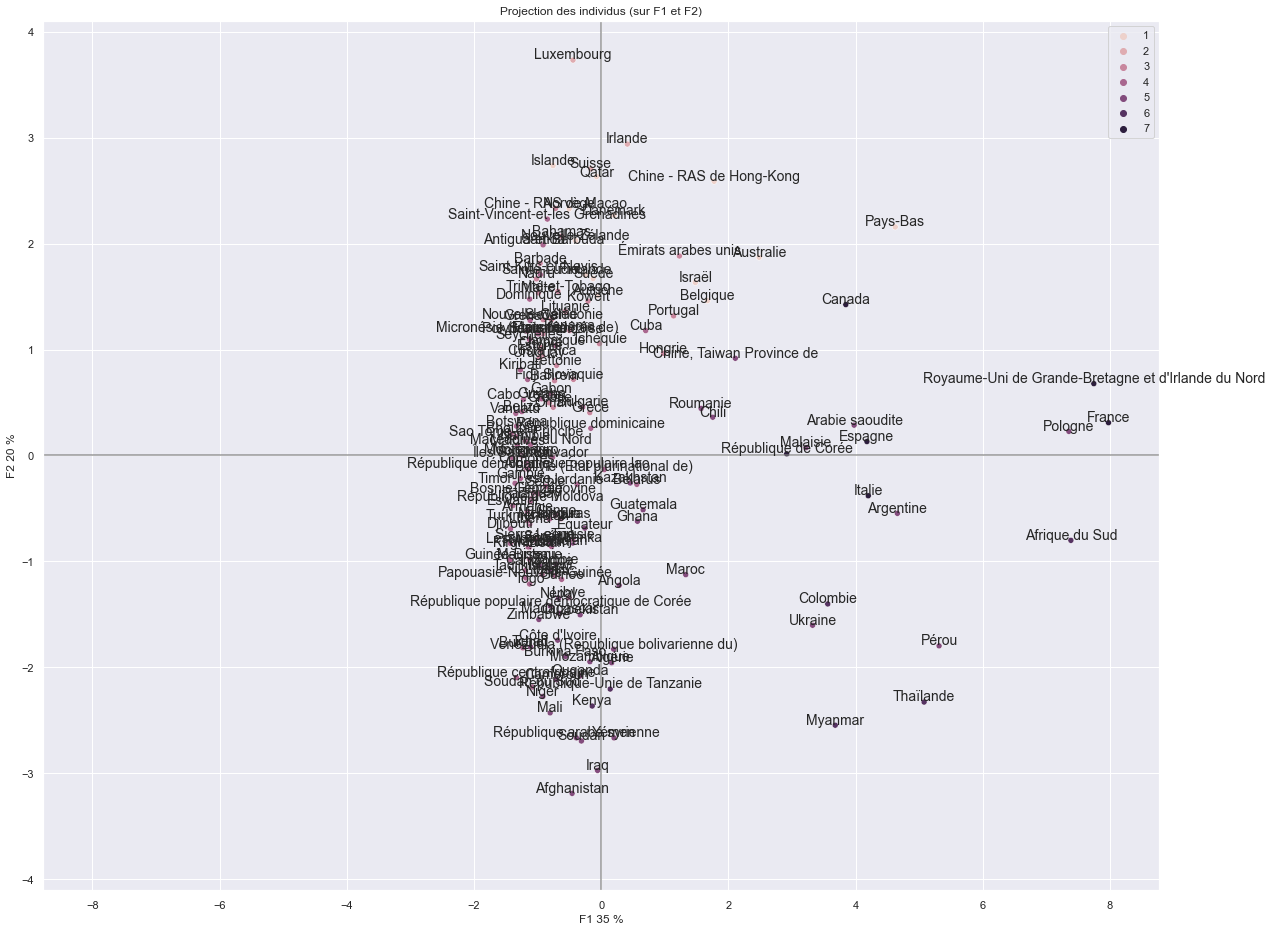

In [626]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o", clusters = CAH)

## Conclusion 

### Analyse métier

On obtient 7 groupes de pays, caractérisés selon les axes F1 et F2 qui expliquent 55% de la variabilité des données

La première composante F1 est principalement corrélée à la production et la disponibilité en volaille.

La seconde composante F2 est elle principalement corrélée à la population, au PIB et à la stabilité politique.

On veut donc cibler des pays avec des valeurs plutôt faibles sur l'axe F1 et des valeurs plutôt élevées sur l'axe F2. Autrement dit, on s'intéresse aux clusters localisés en haut à gauche sur nos graphiques de projections selon les axes F1 et F2.

### Différences entre les méthodes de clustering

Kmeans : Clusters 3 5 7

CAH : clusters 1 2 3

In [627]:
CAH1 = df_volaille2.loc[CAH==1]
CAH2 = df_volaille2.loc[CAH==2]
CAH3 = df_volaille2.loc[CAH==3]
print(CAH1.index)
print(CAH2.index)
print(CAH3.index)

Index(['Australie', 'Autriche', 'Belgique', 'Chine - RAS de Hong-Kong',
       'Danemark', 'Finlande', 'Islande', 'Israël', 'Norvège',
       'Nouvelle-Zélande', 'Pays-Bas', 'Qatar', 'Suède'],
      dtype='object', name='Zone')
Index(['Irlande', 'Luxembourg', 'Suisse'], dtype='object', name='Zone')
Index(['Antigua-et-Barbuda', 'Bahamas', 'Bahreïn', 'Barbade',
       'Chine - RAS de Macao', 'Chypre', 'Costa Rica', 'Croatie', 'Estonie',
       'Grèce', 'Hongrie', 'Koweït', 'Lettonie', 'Lituanie', 'Malte', 'Nauru',
       'Nouvelle-Calédonie', 'Oman', 'Panama', 'Polynésie française',
       'Portugal', 'Saint-Kitts-et-Nevis', 'Slovaquie', 'Slovénie', 'Tchéquie',
       'Trinité-et-Tobago', 'Uruguay', 'Émirats arabes unis'],
      dtype='object', name='Zone')


In [630]:
kmeans1 = df_volaille2.loc[labels==2].index
kmeans2 = df_volaille2.loc[labels==4].index
kmeans3 = df_volaille2.loc[labels==6].index
print(kmeans1)
print(kmeans2)
print(kmeans3)

Index(['Australie', 'Autriche', 'Belgique', 'Chine - RAS de Hong-Kong',
       'Chine - RAS de Macao', 'Danemark', 'Finlande', 'Islande', 'Israël',
       'Norvège', 'Nouvelle-Zélande', 'Pays-Bas', 'Qatar', 'Suède',
       'Émirats arabes unis'],
      dtype='object', name='Zone')
Index(['Irlande', 'Luxembourg', 'Suisse'], dtype='object', name='Zone')
Index(['Antigua-et-Barbuda', 'Bahamas', 'Bahreïn', 'Barbade', 'Chypre',
       'Croatie', 'Estonie', 'Grèce', 'Hongrie', 'Koweït', 'Lettonie',
       'Lituanie', 'Malte', 'Nauru', 'Nouvelle-Calédonie',
       'Polynésie française', 'Portugal', 'Saint-Kitts-et-Nevis', 'Slovaquie',
       'Slovénie', 'Tchéquie', 'Trinité-et-Tobago', 'Uruguay'],
      dtype='object', name='Zone')


Les trois clusters qui nous interessent obtenus pour chacune des deux méthodes contiennent dans l'ensemble les mêmes pays à la différence des quatre pays suivants qui n'ont été inclus dans ces clusters que par la classification hierarchique :
- Costa Rica
- Oman
- Panama
- Emirats arabes unis

Cependant, les centroïdes de la "version CAH" de ce clusters étant plus haute sur l'axe de la deuxième composante, c'est la liste de pays obtenue par la méthode de classification hierarchique que nous allons retenir.

# Conclusion générale 

Liste des pays potentielles cibles : 


In [631]:
liste_pays = pd.concat([CAH1,CAH2,CAH3])

In [632]:
print(liste_pays.index)

Index(['Australie', 'Autriche', 'Belgique', 'Chine - RAS de Hong-Kong',
       'Danemark', 'Finlande', 'Islande', 'Israël', 'Norvège',
       'Nouvelle-Zélande', 'Pays-Bas', 'Qatar', 'Suède', 'Irlande',
       'Luxembourg', 'Suisse', 'Antigua-et-Barbuda', 'Bahamas', 'Bahreïn',
       'Barbade', 'Chine - RAS de Macao', 'Chypre', 'Costa Rica', 'Croatie',
       'Estonie', 'Grèce', 'Hongrie', 'Koweït', 'Lettonie', 'Lituanie',
       'Malte', 'Nauru', 'Nouvelle-Calédonie', 'Oman', 'Panama',
       'Polynésie française', 'Portugal', 'Saint-Kitts-et-Nevis', 'Slovaquie',
       'Slovénie', 'Tchéquie', 'Trinité-et-Tobago', 'Uruguay',
       'Émirats arabes unis'],
      dtype='object', name='Zone')


In [486]:
liste_pays.shape

(44, 10)